# Deep Learning
# DL05-Validacion Dropout Pytorch



## <font color='blue'>**Overfitting y Dropout**</font>

Ahora que se tiene una red entrenada, se puede usar para hacer predicciones. Esto generalmente se llama **inferencia**. Sin embargo, las redes neuronales tienden a funcionar *demasiado bien* en los datos de entrenamiento y no pueden generalizarse a datos que no se han visto antes. Esto se llama **sobreajuste (Overfitting)** y perjudica el rendimiento de la inferencia. Para probar si una red esta sobreajustada durante el entrenamiento, medimos el rendimiento en datos que no están en el conjunto de entrenamiento llamado conjunto de **validación**. Evitamos el sobreajuste a través de la regularización, como el dropout, mientras supervisamos el rendimiento de validación durante el entrenamiento.
 Esta vez aprovecharemos el conjunto de pruebas que puede obtener configurando `train = False` aquí:


```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```
El conjunto de prueba contiene imágenes al igual que el conjunto de entrenamiento. Por lo general, verá el 10-20% del conjunto de datos original para pruebas y validación, y el resto se utilizará para la entrenamiento.

![Backpropagation](https://drive.google.com/uc?export=view&id=1Sf6I7h4gP0EJySDEYt04AfPcBh2zRbmK)

### Características Generales

Vamos a trabajar el concepto de dropout con Fashion-MNIST.
Al igual que su laureado y reconocido predecesor, Fashion-MNIST se compone de imágenes en escala de grises, de 28×28 pixeles.

60.000 imágenes componen Fashion-MNIST, donde 50.000 de ellas son para entrenamiento, y las restantes 10.000 para pruebas. Todas las categorías (10) poseen 6.000 imágenes, lo que implica que el dataset está balanceado.

A diferencia del MNIST tradicional, las categorías no son números del 0 al 9 escritos a mano alzada, sino prendas de vestir, como se puede suponer por su nombre. En particular, estas son las categorías:

1. T-shirt/top (Camiseta o top).
2. Trouser/pants (Pantalones).
3. Pullover shirt (Pullover).
4. Dress (Vestido).
5. Coat (Abrigo).
6. Sandal (Sandalias).
7. Shirt (Camisa).
8. Sneaker (Zapatos deportivos).
9. Bag (Bolso o maleta)
10. Ankle boot (Botines).

### Generemos los conjuntos de entrenamiento y validación.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
import numpy as np

# Se define una normalizacion y trasnformacion de la data.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Cargamos los datos que utilizaremos para entrenar.
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Esto lo hacemos para que el entrenamiento sea mas rapido, bajamos el conjunto.
trainset_sample, trainset_val = random_split(trainset, (10000,50000))
trainloader = torch.utils.data.DataLoader(trainset_sample, batch_size=64, shuffle=True)
# Los tamaños de los batch deben ser iguales porque los tensores deben ser iguales
trainval = torch.utils.data.DataLoader(trainset_val, batch_size=64, shuffle=True)

# Cargamos los datos que utilizamos para validar.
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 7.45MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 64.2MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.95MB/s]


tensor(4)


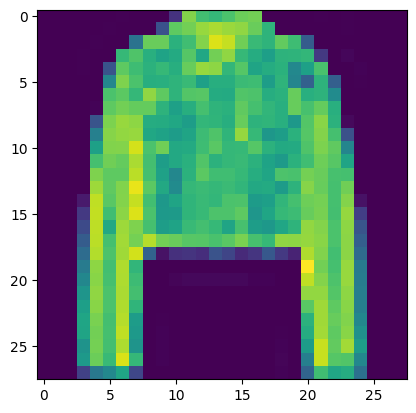

In [2]:
# Miremos el dataset
import matplotlib.pyplot as plt

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[10]
print(labels[10])
img.view(1, 28, 28)
plt.imshow(img.resize_(1, 28, 28).numpy().squeeze())


### Construyendo y evaluando la red.

El objetivo de la validación es medir el rendimiento del modelo en datos que no forman parte del conjunto de entrenamiento.  Por lo general, esto es solo medir la precisión, el porcentaje de clases que la red predijo correctamente. Otras opciones son [__precisión y recuperación__](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_ (class_context)) y la tasa de error de top 5 (__top-k__ nos indica como métrica que el valor correcto está dentro de las __k__ primeras opciones predichas). La  métrica a utilizar va a depender del problema que se está resolviendo. En esta oportunidad, nos centraremos en la precisión.

```
class Classifier(nn.Module):
  def __init__(self):


  def forward(self, x):
  
  
  return x


model = Classifier()

images, labels = next(iter(testloader))
# Obtenga las probabilidades de las clases
ps = torch.exp(model(images))
# Se deberia obtener 10 clases 64 ejemplos.
print(ps.shape)
----------------------------------------------------
torch.Size([64, 10])
```



Con las probabilidades, podemos obtener la clase más probable utilizando el método `ps.topk`. Esto devuelve los valores más altos de $ k $. Como solo queremos la clase más probable, podemos usar `ps.topk (1)`. Esto devuelve una tupla de los valores superiores- $ k $ y los índices superiores- $ k $. Si el valor más alto es el quinto elemento, obtendremos 4 como índice.



```
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])
```



Ahora podemos verificar si las clases predichas coinciden con las etiquetas. Esto es simple de hacer al igualar `top_class` y` labels`, pero debemos tener cuidado con las formas. Aquí `top_class` es un tensor 2D con forma` (64, 1) `mientras que` labels` es 1D con forma `(64)`. Para que la igualdad funcione de la manera que queremos, `top_class` y` labels` deben tener la misma forma.

Si hacemos

```
equals = top_class == labels.view(*top_class.shape)
```

`equals` tendrá forma` (64, 64) `. Lo que está haciendo es comparar un elemento en cada fila de `top_class` con cada elemento en` labels` que devuelve 64 valores booleanos Verdadero / Falso para cada fila.

Ahora necesitamos calcular el porcentaje de predicciones correctas. `equals` tiene valores binarios, ya sea 0 o 1. Esto significa que si solo sumamos todos los valores y dividimos por el número de valores, obtenemos el porcentaje de predicciones correctas. Esta es la misma operación que tomar la media, por lo que podemos obtener la precisión con una llamada a `torch.mean`.

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```
Esto sucede porque `equals` tiene el tipo` torch.ByteTensor` pero `torch.mean` no está implementado para tensores con ese tipo. Por lo tanto, necesitaremos convertir `igual` a un tensor flotante. Tenga en cuenta que cuando tomamos `torch.mean`, devuelve un tensor escalar, para obtener el valor real como flotante necesitaremos hacer` precision.item () `.



```
equals = top_class == labels.view(*top_class.shape)
accuracy = torch.mean(equals.type(torch.FloatTensor)) # Conversion de tipo de datos.
print(f'Accuracy: {accuracy.item()*100}%')
```




La red no está entrenada, por lo que está haciendo conjeturas aleatorias y deberíamos ver una precisión de alrededor del 10%. Ahora entrenemos nuestra red e incluyamos nuestro conjunto de test para que podamos medir qué tan bien está funcionando la red. Como no estamos actualizando nuestros parámetros(gradientes) en el momento  de validar, podemos acelerar el proceso apagando los degradados usando `torch.no_grad ()`:


```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```


## <font color='green'>**Actividad 1**</font>

En esta actividad vamos a entrenar un modelo para clasificar digitos pero adicionalmente incorporaremos el conjunto de validación.

1. Realice el entrenamiento de la red pero incorpore el conjunto de validación.

2. Recuerde apagar los gradientes en la validación.

Analice y utilice el siguiente código para trabajar con el conjunto de validación.

```python
        test_loss = 0
        accuracy = 0
        
        # Apagamos los gradientes para la validación. Permite ahorrar memoria y computo.
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                # Aquí medimos el error en el conjunto de entrenamiento.
                test_loss += criterion(log_ps, labels)
                # Como es logaritmo de la probabilidad, debemos aplicar la exponencial.
                ps = torch.exp(log_ps)
                # La clase top 1.
                top_p, top_class = ps.topk(1, dim=1)
                # equals toma valores True or False.
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
```
3. Imprima el Trainig Loss, Test loss y Test Accuracy.
4. Genere las gráficas.

Para que no sea tan lento ponga como máximo 5 epochs.



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.62MB/s]


Iniciando entrenamiento...
Epoch: 1/5..  Training Loss: 0.473..  Test Loss: 0.218..  Test Accuracy: 0.936
Epoch: 2/5..  Training Loss: 0.291..  Test Loss: 0.174..  Test Accuracy: 0.945
Epoch: 3/5..  Training Loss: 0.261..  Test Loss: 0.149..  Test Accuracy: 0.956
Epoch: 4/5..  Training Loss: 0.243..  Test Loss: 0.142..  Test Accuracy: 0.956
Epoch: 5/5..  Training Loss: 0.230..  Test Loss: 0.164..  Test Accuracy: 0.955
Entrenamiento finalizado!


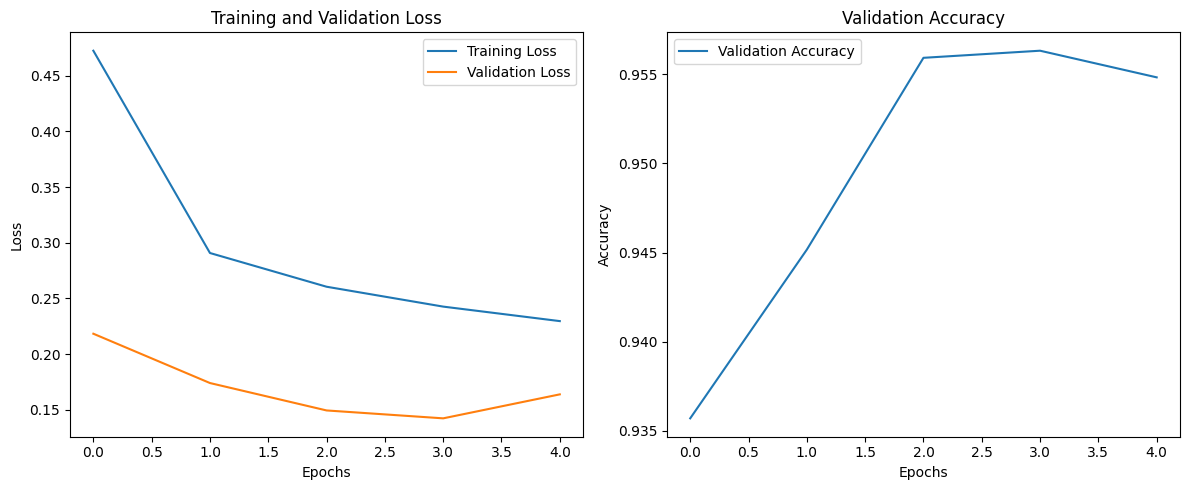

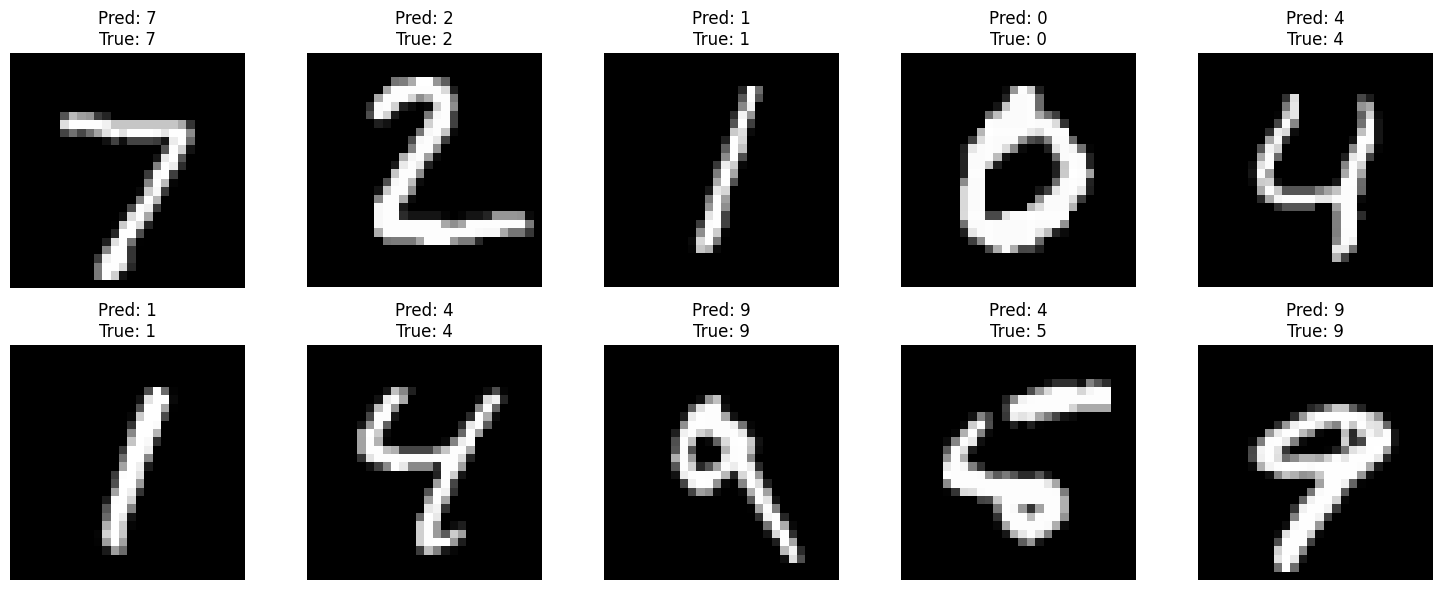


Análisis de resultados:
Pérdida final de entrenamiento: 0.2297
Pérdida final de validación: 0.1639
Precisión final de validación: 0.9548

Mejor rendimiento en validación:
Epoch: 4
Pérdida de validación: 0.1423
Precisión de validación: 0.9563


In [3]:
# Aqui el codigo

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Definir transformaciones para los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Descargar y cargar los datasets
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Crear los dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Definir la arquitectura de la red neuronal
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Definir dropout para evitar sobreajuste
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Aplanar la imagen de entrada
        x = x.view(x.shape[0], -1)

        # Capa 1: Linear -> ReLU -> Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # Capa 2: Linear -> ReLU -> Dropout
        x = self.dropout(F.relu(self.fc2(x)))
        # Capa 3: Linear -> ReLU -> Dropout
        x = self.dropout(F.relu(self.fc3(x)))
        # Capa de salida con log_softmax
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# Inicializar la red, el criterio de pérdida y el optimizador
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Configurar parámetros de entrenamiento
epochs = 5
train_losses = []
test_losses = []
test_accuracies = []

print("Iniciando entrenamiento...")

# Ciclo de entrenamiento
for e in range(epochs):
    running_loss = 0

    # Entrenar el modelo
    model.train()  # Establecer el modelo en modo de entrenamiento
    for images, labels in trainloader:
        # Limpiar los gradientes acumulados
        optimizer.zero_grad()

        # Pasar la imagen a través del modelo
        log_ps = model(images)
        # Calcular la pérdida
        loss = criterion(log_ps, labels)
        # Calcular los gradientes
        loss.backward()
        # Actualizar los pesos
        optimizer.step()

        running_loss += loss.item()

    # Validar el modelo
    test_loss = 0
    accuracy = 0

    # Cambiar a modo de evaluación
    model.eval()  # Establecer el modelo en modo de evaluación

    # Apagar los gradientes para la validación
    with torch.no_grad():
        for images, labels in testloader:
            # Pasar la imagen a través del modelo
            log_ps = model(images)
            # Calcular la pérdida en el conjunto de prueba
            test_loss += criterion(log_ps, labels)

            # Convertir log-probabilidades a probabilidades
            ps = torch.exp(log_ps)
            # Obtener la clase con mayor probabilidad
            top_p, top_class = ps.topk(1, dim=1)
            # Verificar si la predicción es correcta
            equals = top_class == labels.view(*top_class.shape)
            # Calcular la precisión
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    # Guardar las métricas para graficar
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    test_accuracies.append(accuracy/len(testloader))

    # Imprimir el progreso del entrenamiento
    print(f"Epoch: {e+1}/{epochs}.. ",
          f"Training Loss: {running_loss/len(trainloader):.3f}.. ",
          f"Test Loss: {test_loss/len(testloader):.3f}.. ",
          f"Test Accuracy: {accuracy/len(testloader):.3f}")

print("Entrenamiento finalizado!")

# Graficar los resultados
plt.figure(figsize=(12, 5))

# Subplot para las pérdidas
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot para la precisión
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en un lote de imágenes
model.eval()
images, labels = next(iter(testloader))

# Obtener las predicciones
with torch.no_grad():
    log_ps = model(images)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)

# Visualizar algunas predicciones
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].view(28, 28).numpy(), cmap='gray')
    ax.set_title(f'Pred: {top_class[i].item()}\nTrue: {labels[i].item()}')
    ax.axis('off')

plt.show()

# Análisis final
print("\nAnálisis de resultados:")
print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {test_losses[-1]:.4f}")
print(f"Precisión final de validación: {test_accuracies[-1]:.4f}")

# Encontrar el epoch con el mejor rendimiento en validación
best_epoch = np.argmin(test_losses)
print(f"\nMejor rendimiento en validación:")
print(f"Epoch: {best_epoch + 1}")
print(f"Pérdida de validación: {test_losses[best_epoch]:.4f}")
print(f"Precisión de validación: {test_accuracies[best_epoch]:.4f}")

Conclusiones:
La curva de entrenamiento nos muestra una reducción casi monotónica del error. Sin embargo, cuando aplicamos el modelo en el set de pruebas, vemos que, despues de una bajada, se observa una pendiente de subida en el __validation loss__. Deberemos encontrar cual es el conjunto de parámetros que entregó ese valor míniomo del error.

<font color='green'>**Fin Actividad 1**</font>

### Overfitting

Si observamos los errores  de entrenamiento y validación a medida que entrenamos la red, podemos ver un fenómeno conocido como sobreajuste.


![OverFitting](https://drive.google.com/uc?export=view&id=1q2B9ov7gq0-Ae1-_2QWqBMJ1FP8tmBYM)


La red aprende el conjunto de entrenamiento cada vez mejor, lo que resulta en menores errores de entrenamiento. Sin embargo, comienza a tener problemas para generalizar los datos fuera del conjunto de entrenamiento, lo que lleva a que aumente el error de validación. El objetivo final de cualquier modelo de aprendizaje profundo es hacer predicciones sobre nuevos datos, por lo que debemos esforzarnos por obtener el menor error de validación posible. Una opción es usar la versión del modelo con la pérdida de validación más baja, aquí la de alrededor de 8-10 épocs de entrenamiento. Esta estrategia se llama *parada anticipada*. En la práctica, guardaría el modelo con frecuencia mientras entrena y luego elegiría el modelo con la menor pérdida de validación.

El método más común para reducir el sobreajuste (fuera de la detención anticipada) es *dropout*, donde abandonamos aleatoriamente las unidades de entrada. Esto obliga a la red a compartir información entre pesos, lo que aumenta su capacidad de generalizar a nuevos datos. Agregar abandono en PyTorch es sencillo usando el módulo [`nn.Dropout`] (https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout).


```python
        x = self.dropout(F.relu(self.fc3(x)))
        return x
```
Durante el entrenamiento queremos usar el dropout para evitar el sobreajuste, pero durante la inferencia queremos usar toda la red. Por lo tanto, debemos desactivar el abandono durante la validación, las pruebas y cada vez que usemos la red para hacer predicciones. Para hacer esto, usa `model.eval ()`. Esto establece el modelo en modo de evaluación donde la probabilidad de abandono es 0. Puede volver a activar el abandono configurando el modelo en modo de entrenamiento con `model.train ()`. En general, el patrón para el bucle de validación se verá así, donde apaga los gradientes, establece el modelo en modo de evaluación, calcula la pérdida de validación y la métrica, luego establece el modelo nuevamente en modo de entrenamiento.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

## <font color='green'>**Actividad 2**</font>

Implemente equivalente a la **Actividad 2**, pero utilizando dropout.

Iniciando entrenamiento con dropout...
Epoch: 1/30..  Training Loss: 0.975..  Test Loss: 0.408..  Test Accuracy: 0.889
Epoch: 2/30..  Training Loss: 0.692..  Test Loss: 0.330..  Test Accuracy: 0.910
Epoch: 3/30..  Training Loss: 0.666..  Test Loss: 0.344..  Test Accuracy: 0.903
Epoch: 4/30..  Training Loss: 0.644..  Test Loss: 0.297..  Test Accuracy: 0.915
Epoch: 5/30..  Training Loss: 0.614..  Test Loss: 0.321..  Test Accuracy: 0.912
Epoch: 6/30..  Training Loss: 0.619..  Test Loss: 0.321..  Test Accuracy: 0.912
Epoch: 7/30..  Training Loss: 0.611..  Test Loss: 0.287..  Test Accuracy: 0.920
Epoch: 8/30..  Training Loss: 0.604..  Test Loss: 0.310..  Test Accuracy: 0.917
Epoch: 9/30..  Training Loss: 0.605..  Test Loss: 0.285..  Test Accuracy: 0.924
Epoch: 10/30..  Training Loss: 0.601..  Test Loss: 0.274..  Test Accuracy: 0.923
Epoch: 11/30..  Training Loss: 0.598..  Test Loss: 0.270..  Test Accuracy: 0.924
Epoch: 12/30..  Training Loss: 0.592..  Test Loss: 0.313..  Test Accuracy: 0.91

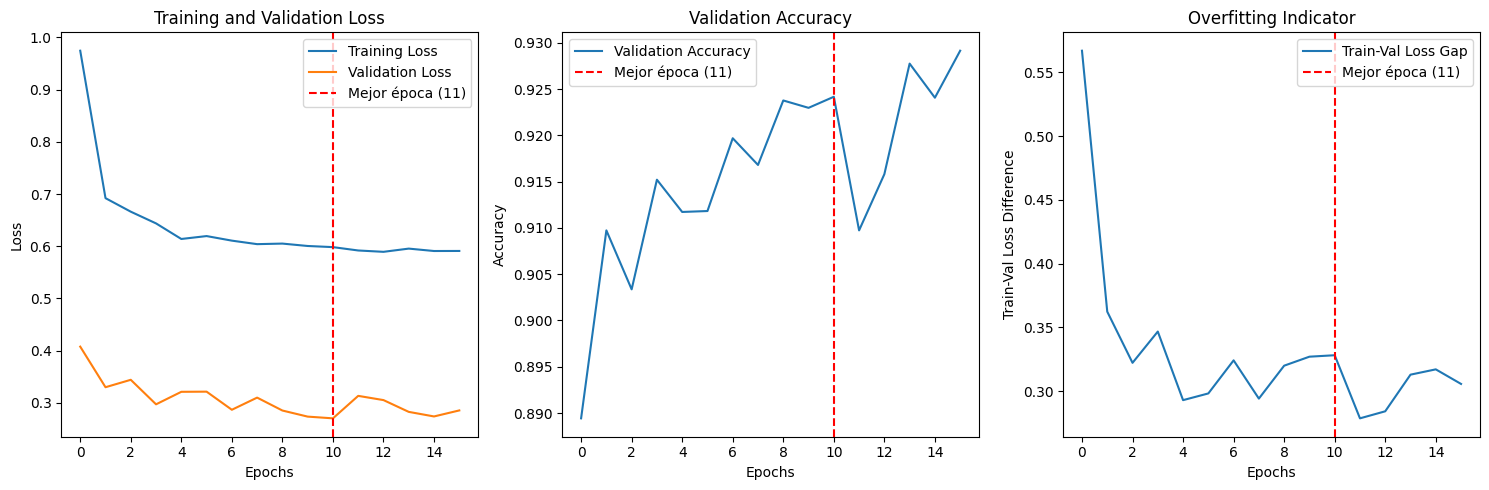


Métricas avanzadas de clasificación:
Precision: 0.9289
Recall: 0.9277
F1-Score: 0.9279


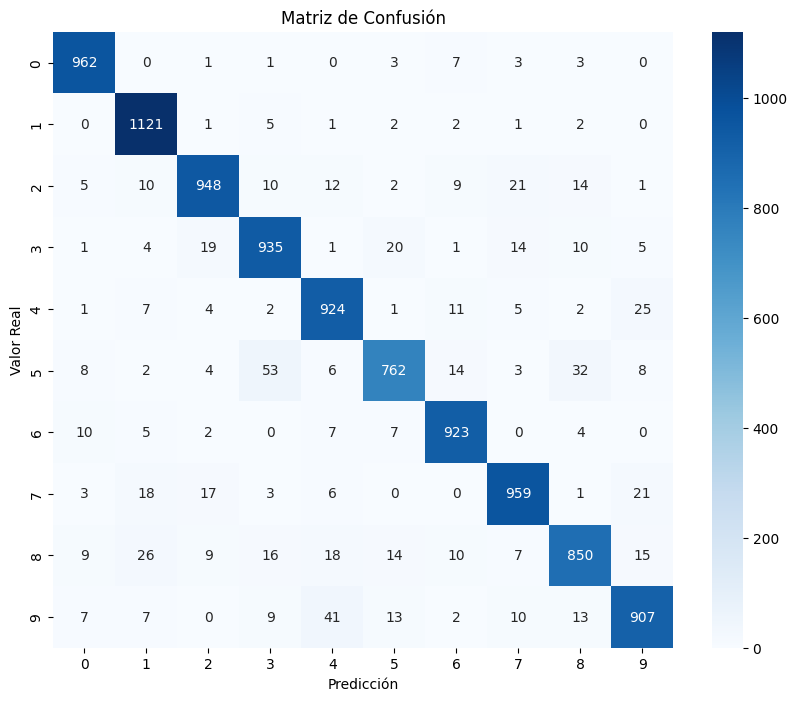

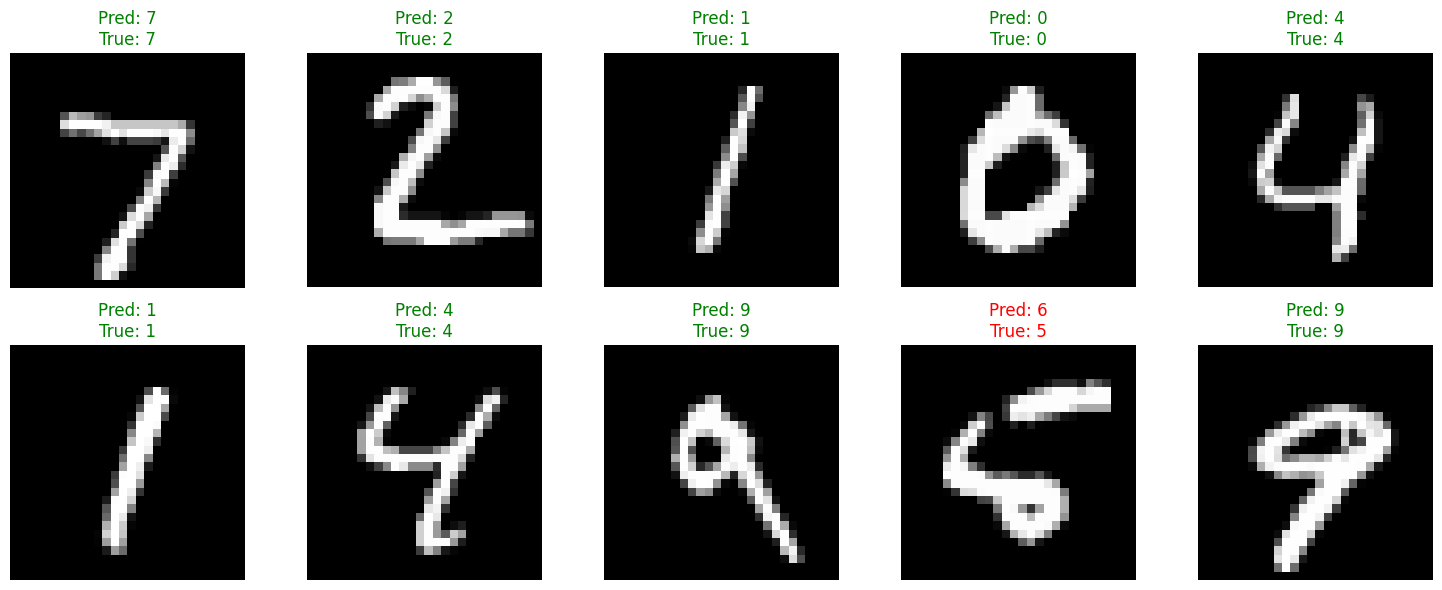


Análisis de resultados:
Pérdida final de entrenamiento: 0.5910
Pérdida final de validación: 0.2854
Precisión final de validación: 0.9291

Mejor rendimiento en validación (Early Stopping):
Epoch: 11
Pérdida de entrenamiento: 0.5983
Pérdida de validación: 0.2703
Precisión de validación: 0.9242

Guardando el mejor modelo...
Modelo guardado como 'best_mnist_model_with_dropout.pth'


In [4]:
# Aqui el codigo

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Definir transformaciones para los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Descargar y cargar los datasets
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Crear los dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Definir la arquitectura de la red neuronal con dropout
class ClassifierWithDropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Incrementamos la probabilidad de dropout para mostrar más claramente su efecto
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # Aplanar la imagen de entrada
        x = x.view(x.shape[0], -1)

        # Aplica dropout después de cada capa oculta
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # Capa de salida con log_softmax (sin dropout en la salida)
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# Inicializar la red, el criterio de pérdida y el optimizador
model = ClassifierWithDropout(dropout_prob=0.5)  # Valor relativamente alto para mostrar el efecto
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Configurar parámetros de entrenamiento
epochs = 30  # Entrenamos por más épocas para ver claramente el sobreajuste y el efecto del dropout
train_losses = []
test_losses = []
test_accuracies = []

# Variables para early stopping
best_val_loss = float('inf')
best_model_state = None
patience = 5  # Número de épocas a esperar antes de parar si no hay mejora
counter = 0

print("Iniciando entrenamiento con dropout...")

# Ciclo de entrenamiento
for e in range(epochs):
    # Configurar modelo en modo de entrenamiento (activa dropout)
    model.train()

    running_loss = 0

    # Entrenar el modelo
    for images, labels in trainloader:
        # Limpiar los gradientes acumulados
        optimizer.zero_grad()

        # Pasar la imagen a través del modelo
        log_ps = model(images)
        # Calcular la pérdida
        loss = criterion(log_ps, labels)
        # Calcular los gradientes
        loss.backward()
        # Actualizar los pesos
        optimizer.step()

        running_loss += loss.item()

    # Validar el modelo
    test_loss = 0
    accuracy = 0

    # Configurar modelo en modo de evaluación (desactiva dropout)
    model.eval()

    # Apagar los gradientes para la validación
    with torch.no_grad():
        for images, labels in testloader:
            # Pasar la imagen a través del modelo
            log_ps = model(images)
            # Calcular la pérdida en el conjunto de prueba
            test_loss += criterion(log_ps, labels)

            # Convertir log-probabilidades a probabilidades
            ps = torch.exp(log_ps)
            # Obtener la clase con mayor probabilidad
            top_p, top_class = ps.topk(1, dim=1)
            # Verificar si la predicción es correcta
            equals = top_class == labels.view(*top_class.shape)
            # Calcular la precisión
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    # Calcular las métricas promedio
    avg_train_loss = running_loss/len(trainloader)
    avg_test_loss = test_loss/len(testloader)
    avg_accuracy = accuracy/len(testloader)

    # Guardar las métricas para graficar
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_accuracy)

    # Imprimir el progreso del entrenamiento
    print(f"Epoch: {e+1}/{epochs}.. ",
          f"Training Loss: {avg_train_loss:.3f}.. ",
          f"Test Loss: {avg_test_loss:.3f}.. ",
          f"Test Accuracy: {avg_accuracy:.3f}")

    # Comprobar early stopping
    if avg_test_loss < best_val_loss:
        best_val_loss = avg_test_loss
        best_model_state = model.state_dict().copy()
        counter = 0  # Resetear contador
    else:
        counter += 1

    # Si no hay mejora en 'patience' épocas, detener el entrenamiento
    if counter >= patience:
        print(f"\nEarly stopping en época {e+1}")
        print(f"Mejor pérdida de validación: {best_val_loss:.4f}")
        break

print("Entrenamiento finalizado!")

# Cargar el mejor modelo (si se activó early stopping)
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Mejor modelo cargado!")

# Graficar los resultados
plt.figure(figsize=(15, 5))

# Subplot para las pérdidas
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.axvline(x=np.argmin(test_losses), color='r', linestyle='--',
           label=f'Mejor época ({np.argmin(test_losses)+1})')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot para la precisión
plt.subplot(1, 3, 2)
plt.plot(test_accuracies, label='Validation Accuracy')
plt.axvline(x=np.argmin(test_losses), color='r', linestyle='--',
           label=f'Mejor época ({np.argmin(test_losses)+1})')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot para la diferencia entre train y validation loss
plt.subplot(1, 3, 3)
loss_diff = [train - test for train, test in zip(train_losses, test_losses)]
plt.plot(loss_diff, label='Train-Val Loss Gap')
plt.axvline(x=np.argmin(test_losses), color='r', linestyle='--',
           label=f'Mejor época ({np.argmin(test_losses)+1})')
plt.title('Overfitting Indicator')
plt.xlabel('Epochs')
plt.ylabel('Train-Val Loss Difference')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular métricas adicionales (precision, recall, F1-score)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        log_ps = model(images)
        ps = torch.exp(log_ps)
        _, predicted = torch.max(ps, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calcular precisión, recall y F1-score
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\nMétricas avanzadas de clasificación:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Crear matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Visualizar algunas predicciones
model.eval()
images, labels = next(iter(testloader))

# Obtener las predicciones
with torch.no_grad():
    log_ps = model(images)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)

# Visualizar algunas predicciones
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.tight_layout()

for i, ax in enumerate(axes.flatten()):
    # Mostrar la imagen original (invirtiendo la normalización)
    img = images[i].view(28, 28).numpy()
    ax.imshow(img, cmap='gray')
    correct = top_class[i].item() == labels[i].item()
    color = 'green' if correct else 'red'
    ax.set_title(f'Pred: {top_class[i].item()}\nTrue: {labels[i].item()}', color=color)
    ax.axis('off')

plt.show()

# Análisis final
best_epoch = np.argmin(test_losses)
print("\nAnálisis de resultados:")
print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {test_losses[-1]:.4f}")
print(f"Precisión final de validación: {test_accuracies[-1]:.4f}")

print(f"\nMejor rendimiento en validación (Early Stopping):")
print(f"Epoch: {best_epoch + 1}")
print(f"Pérdida de entrenamiento: {train_losses[best_epoch]:.4f}")
print(f"Pérdida de validación: {test_losses[best_epoch]:.4f}")
print(f"Precisión de validación: {test_accuracies[best_epoch]:.4f}")

# Guardar el mejor modelo
print("\nGuardando el mejor modelo...")
torch.save(model.state_dict(), 'best_mnist_model_with_dropout.pth')
print("Modelo guardado como 'best_mnist_model_with_dropout.pth'")

Conclusiones:
- Podemos guardar los objetos del modelo y los valores de los errores para comparar iteración a iteración y determinar, después de muchas de ellas, cual fue el menor.
- Cuando usemos nuestro modelo ya entrenado, hay que ponerlo en modeo evaluación: `model.eval()`.
- Con los vectores de salida, el $y$ y el $\hat{y}$, podemos calcular todas las métrixcas típicas de una clasifiación (__presition, recall, F-1 Score__).


<font color='green'>**Fin Actividad 2**</font>

## Inferencia

Ahora que el modelo está entrenado, podemos usarlo para inferencia. Debemos configurar el modelo en modo de inferencia con `model.eval()`. También querrás desactivar autograd con `torch.no_grad()`.

Veamos como se realiza esto con Pytorch.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

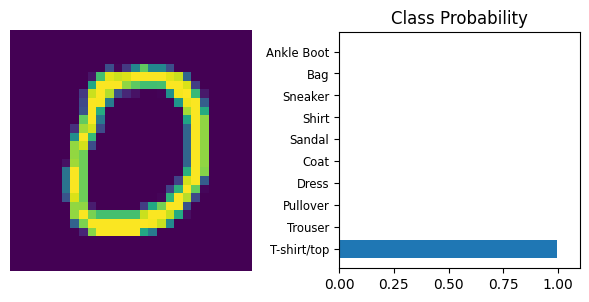

In [6]:
# Probemos nuestra red.

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[10]
# Convirtiendo la imagen 2D a vector 1D.
img = img.view(1, 784)

# Calculando la probabilidad de las clases.
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Dibujando la imagen y las probabilidedes de las clases.
view_classify(img.view(1, 28, 28), ps, version='Fashion')

<img src="https://drive.google.com/uc?export=view&id=1DNuGbS1i-9it4Nyr3ZMncQz9cRhs2eJr" width="100" align="left" title="Runa-perth">
<br clear="left">

## <font color='green'>**Regularizaciones.**</font>

La regularización es una técnica en aprendizaje automático y estadísticas que se utiliza para prevenir el sobreajuste (overfitting) de un modelo a los datos de entrenamiento. El sobreajuste ocurre cuando un modelo se ajusta tan bien a los datos de entrenamiento que pierde su capacidad para generalizar a datos no vistos. La regularización actúa como una restricción en la capacidad del modelo para adaptarse completamente a los datos de entrenamiento, lo que permite que el modelo generalice mejor.

Hay varios métodos de regularización que se utilizan en aprendizaje automático. Algunos de los más comunes son:

Regularización L1 (Lasso): Agrega una penalización proporcional al valor absoluto de los parámetros del modelo. Esto puede resultar en que algunos parámetros se vuelvan exactamente cero, lo que efectivamente elimina algunas características del modelo.

Regularización L2 (Ridge): Agrega una penalización proporcional al cuadrado de los parámetros del modelo. Esto tiende a reducir los valores de los parámetros sin hacer que se vuelvan cero.

Regularización L1 y L2 combinadas (ElasticNet): Combina las penalizaciones de L1 y L2.

Dropout: Es una técnica de regularización específica para redes neuronales. Durante el entrenamiento, algunas neuronas se "desactivan" al azar con una cierta probabilidad, lo que significa que no se utilizan durante el paso de propagación hacia adelante. Esto evita que la red se vuelva demasiado dependiente de cualquier neurona individual y mejora la generalización.

En PyTorch, la regularización L1 y L2 se puede implementar especificando el argumento weight_decay al optimizador. El dropout se puede implementar utilizando la capa nn.Dropout.

Aquí hay un ejemplo de cómo implementar regularización L2 y dropout en PyTorch:

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definir la arquitectura de la red neuronal con dropout
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5) # Probabilidad de 0.5 de desactivar una neurona

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instanciar la red neuronal
model = Network()

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Definir el optimizador con regularización L2 (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)


En este ejemplo, hemos definido una red neuronal con una capa de dropout que desactivará al azar el 50% de las neuronas durante el entrenamiento. También hemos definido un optimizador con regularización L2 utilizando el argumento weight_decay.  

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Definir la arquitectura de la red neuronal
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instanciar la red neuronal
model = Network()

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la penalización L1
l1_lambda = 0.01

def l1_penalty(model):
    l1_norm = sum(torch.norm(param, 1) for param in model.parameters())
    return l1_lambda * l1_norm

# Durante el entrenamiento (Ejemplo)
# Suponiendo que tienes 'inputs' y 'labels' para tu lote de entrenamiento
# outputs = model(inputs)
# loss = criterion(outputs, labels)
# l1_loss = l1_penalty(model)
# total_loss = loss + l1_loss
# total_loss.backward()
# optimizer.step()




En este ejemplo, hemos añadido la penalización L1 a la función de pérdida utilizando el método torch.norm con el argumento 1 para calcular la norma L1 de los parámetros del modelo.

<img src="https://drive.google.com/uc?export=view&id=1Igtn9UXg6NGeRWsqh4hefQUjV0hmzlBv" width="100" align="left" title="Runa-perth">
<br clear="left">

## <font color='red'>**Otros métodos de regularización.**</font>

**Normalización de lote (Batch Normalization)**: Esta técnica normaliza las entradas de cada capa, pero lo hace diferente para cada mini-lote en el entrenamiento. La normalización se realiza sobre el conjunto de datos del mini-lote en lugar de todo el conjunto de datos. La idea es reducir el cambio en la distribución de las entradas durante el entrenamiento, lo que puede acelerar el proceso de entrenamiento y mejorar el rendimiento del modelo.

**Normalización de capa (Layer Normalization)**: A diferencia de la normalización de lote, la normalización de capa normaliza las entradas de la capa a través de las características en lugar de los ejemplos en el lote. La normalización se realiza para cada ejemplo en el mini-lote de manera independiente. Esto la hace menos sensible al tamaño del lote y puede ser útil en situaciones en las que el tamaño del lote varía.

**Normalización de instancia (Instance Normalization)**: Similar a la normalización de capa, pero se aplica principalmente en tareas de visión por computadora como la transferencia de estilo. Normaliza cada canal de una imagen de manera independiente.

**Normalización de grupo (Group Normalization)**: Divide los canales en grupos y normaliza los valores dentro de cada grupo. Se utiliza en tareas de visión por computadora y es útil en situaciones en las que el tamaño del lote es pequeño.

**Normalización de peso (Weight Normalization)**: En lugar de normalizar las entradas, la normalización de peso normaliza los pesos de la capa.

In [9]:
import torch.nn as nn

class BatchNormModel(nn.Module):
    def __init__(self):
        super(BatchNormModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        return x


In [10]:
import torch.nn as nn

class LayerNormModel(nn.Module):
    def __init__(self):
        super(LayerNormModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.ln1 = nn.LayerNorm(50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.fc2(x)
        return x


In [11]:
import torch.nn as nn

class InstanceNormModel(nn.Module):
    def __init__(self):
        super(InstanceNormModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.in1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.in1(x)
        x = self.conv2(x)
        return x


In [12]:
import torch.nn as nn

class GroupNormModel(nn.Module):
    def __init__(self):
        super(GroupNormModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.gn1 = nn.GroupNorm(32, 64) # 32 groups, 64 channels
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.conv2(x)
        return x


In [13]:
import torch.nn as nn
import torch.nn.utils as utils

class WeightNormModel(nn.Module):
    def __init__(self):
        super(WeightNormModel, self).__init__()
        self.fc1 = utils.weight_norm(nn.Linear(10, 50))
        self.fc2 = utils.weight_norm(nn.Linear(50, 1))

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x


## <font color='green'>**Actividad 3**</font>

**Clasificación de dígitos manuscritos con MNIST**

Objetivo: Mejorar la precisión de un modelo de red neuronal en un conjunto de datos de validación mediante la aplicación y ajuste de técnicas de regularización.

Instrucciones:

Carga el conjunto de datos MNIST.
Define una red neuronal simple.
Entrena el modelo sin regularización y evalúa su desempeño.
Modifica el modelo para incluir dropout y regularización L2.
Ajusta el tamaño del lote y observa el efecto en la convergencia y precisión del modelo.
Compara los resultados de ambos modelos.

Observa la precisión de ambos modelos en el conjunto de prueba. ¿El modelo con regularización tiene un mejor desempeño?

Modifica el valor del parámetro dropout_p en el modelo. ¿Cómo afecta al desempeño del modelo?

Cambia el valor de weight_decay (regularización L2). ¿Cuál es el impacto en la precisión?

Ajusta el batch_size en los DataLoaders. ¿Cómo afecta la velocidad de convergencia y la precisión?

In [14]:
# Importa las bibliotecas necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

# 1. Carga el conjunto de datos MNIST
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define una red neuronal simple
class SimpleNN(nn.Module):
    def __init__(self, dropout_p=0.0):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 10)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Función de entrenamiento
def train(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Función de evaluación
def evaluate(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# 3. Entrena el modelo sin regularización
model1 = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
train(model1, train_loader, criterion, optimizer, epochs=5)
evaluate(model1, test_loader)

# 4. Modifica el modelo para incluir dropout y regularización L2
model2 = SimpleNN(dropout_p=0.5)
optimizer = optim.Adam(model2.parameters(), lr=0.001, weight_decay=0.01) # Regularización L2 con weight_decay
train(model2, train_loader, criterion, optimizer, epochs=5)
evaluate(model2, test_loader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.30MB/s]


Accuracy: 97.73%
Accuracy: 91.78%


Análisis de Técnicas de Regularización en Redes Neuronales para MNIST
Utilizando dispositivo: cuda

--- Ejecutando experimento: Base (Sin Regularización) ---
Base (Sin Regularización) - Época 1/5 | Tiempo: 22.00s | Train Loss: 0.2062 | Train Acc: 93.75% | Test Loss: 0.0996 | Test Acc: 96.84%
Base (Sin Regularización) - Época 2/5 | Tiempo: 15.56s | Train Loss: 0.0854 | Train Acc: 97.33% | Test Loss: 0.0917 | Test Acc: 97.15%
Base (Sin Regularización) - Época 3/5 | Tiempo: 16.15s | Train Loss: 0.0606 | Train Acc: 98.13% | Test Loss: 0.0838 | Test Acc: 97.43%
Base (Sin Regularización) - Época 4/5 | Tiempo: 15.53s | Train Loss: 0.0455 | Train Acc: 98.56% | Test Loss: 0.0742 | Test Acc: 97.68%
Base (Sin Regularización) - Época 5/5 | Tiempo: 15.57s | Train Loss: 0.0372 | Train Acc: 98.78% | Test Loss: 0.0684 | Test Acc: 97.91%

Base (Sin Regularización) completado en 84.80 segundos
Precisión final en prueba: 97.91%

--- Ejecutando experimento: Con Regularización (Dropout 0.5, L2 0.01) ---
Co

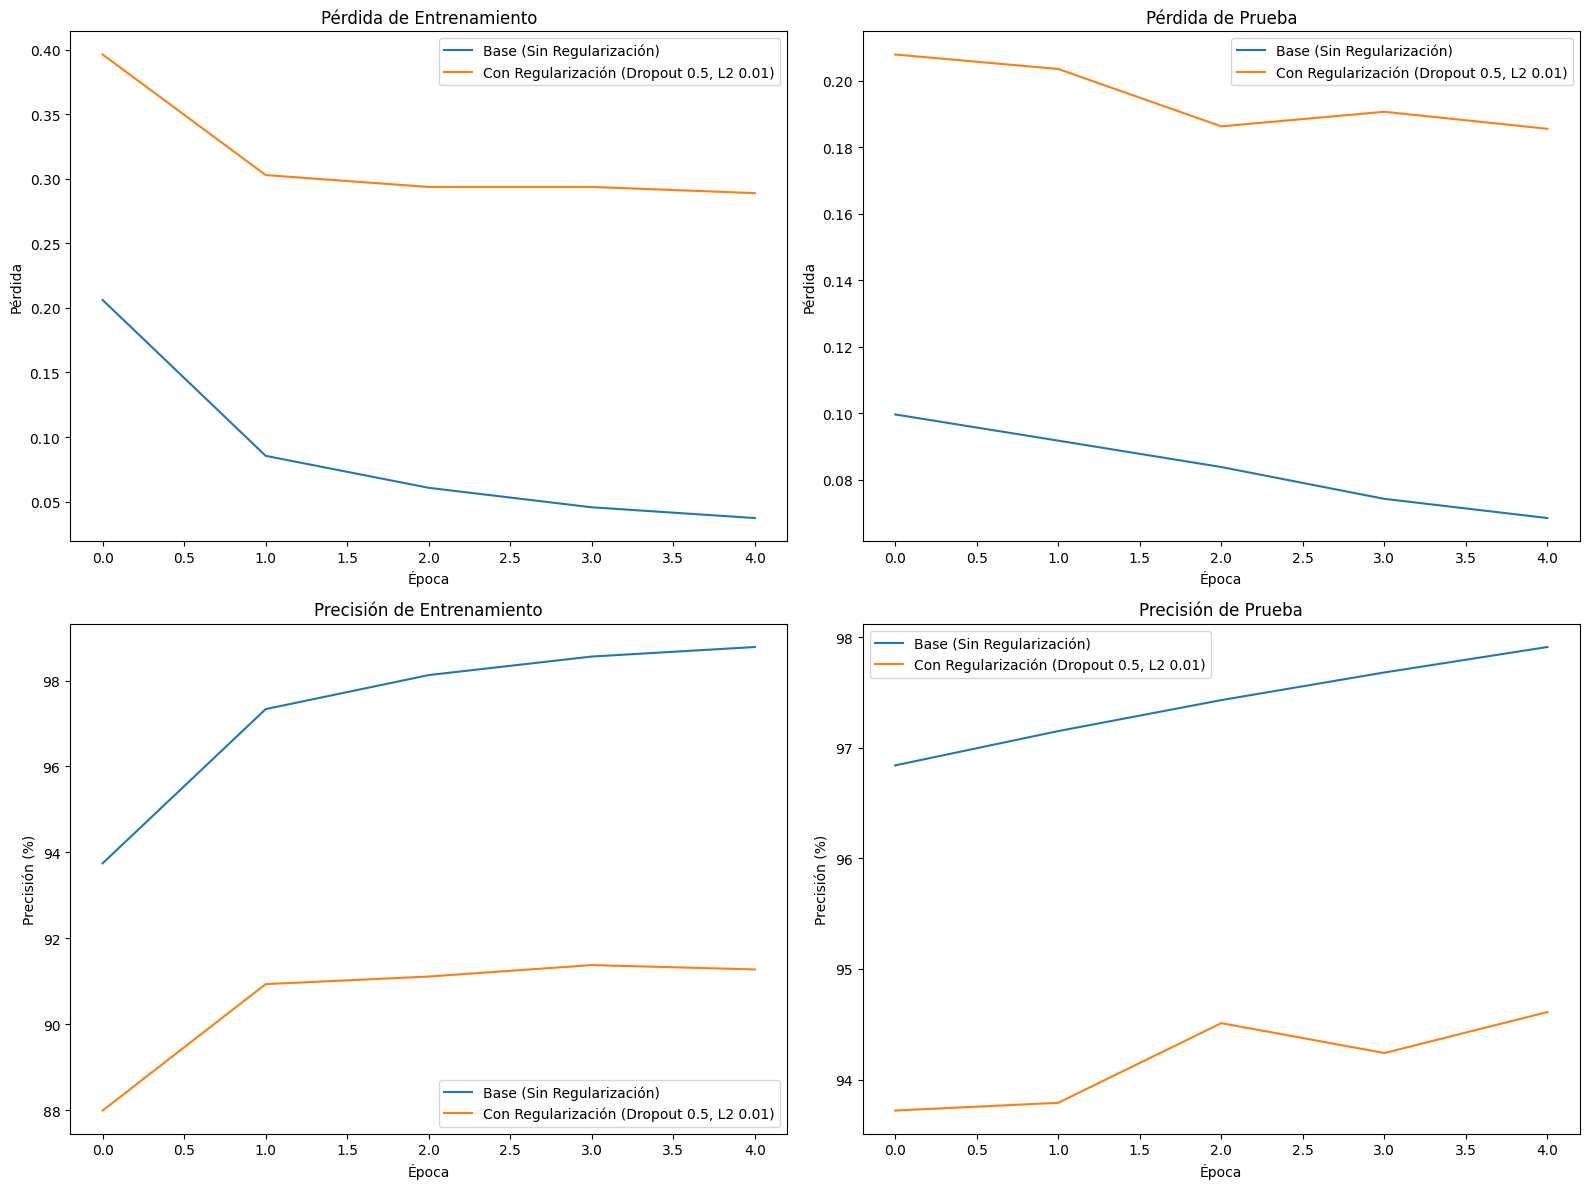

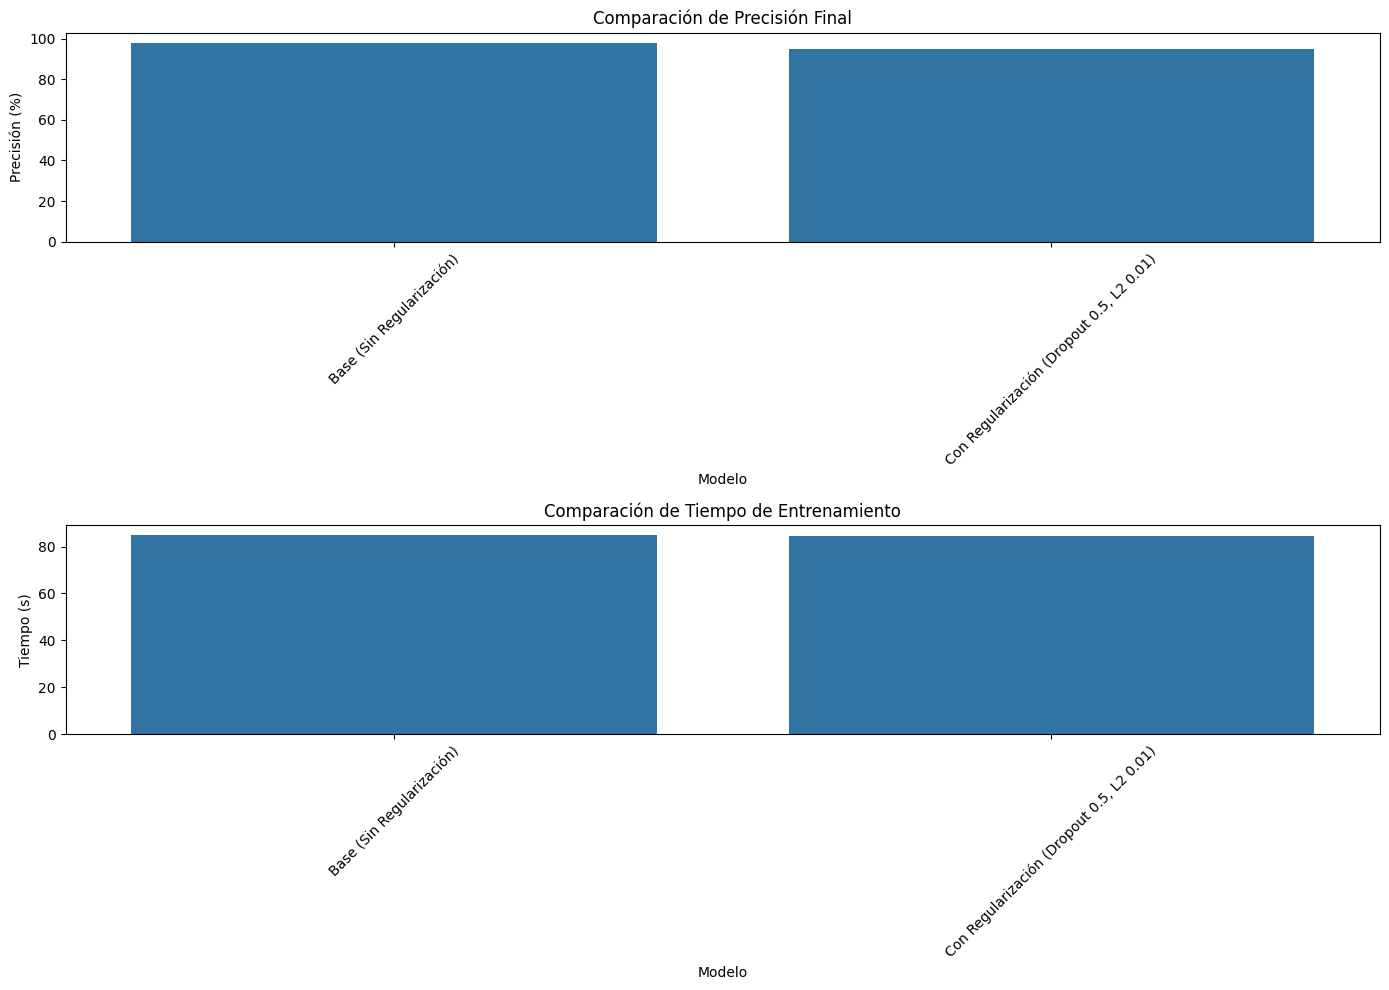

Base (Sin Regularización) - Época 5/5 | Tiempo: 16.64s | Train Loss: 0.0363 | Train Acc: 98.80% | Test Loss: 0.0846 | Test Acc: 97.61%

Base (Sin Regularización) completado en 83.63 segundos
Precisión final en prueba: 97.61%
Con Regularización (Dropout 0.5, L2 0.01) - Época 5/5 | Tiempo: 17.95s | Train Loss: 0.2928 | Train Acc: 91.24% | Test Loss: 0.1885 | Test Acc: 94.59%

Con Regularización (Dropout 0.5, L2 0.01) completado en 87.11 segundos
Precisión final en prueba: 94.59%


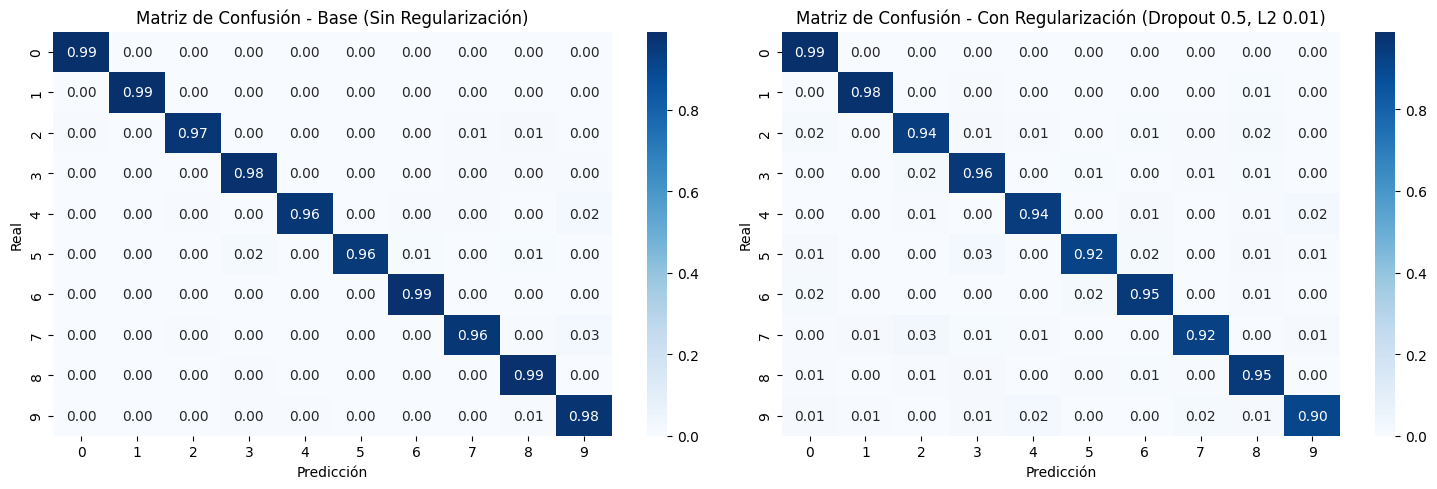


=== Análisis del efecto del dropout ===
Utilizando dispositivo: cuda

--- Ejecutando experimento: dropout_p=0.0 ---
dropout_p=0.0 - Época 1/5 | Tiempo: 17.58s | Train Loss: 0.2050 | Train Acc: 93.83% | Test Loss: 0.1023 | Test Acc: 96.71%
dropout_p=0.0 - Época 2/5 | Tiempo: 16.99s | Train Loss: 0.0891 | Train Acc: 97.15% | Test Loss: 0.0852 | Test Acc: 97.36%
dropout_p=0.0 - Época 3/5 | Tiempo: 17.96s | Train Loss: 0.0600 | Train Acc: 98.04% | Test Loss: 0.0666 | Test Acc: 97.89%
dropout_p=0.0 - Época 4/5 | Tiempo: 17.51s | Train Loss: 0.0483 | Train Acc: 98.46% | Test Loss: 0.0761 | Test Acc: 97.91%
dropout_p=0.0 - Época 5/5 | Tiempo: 17.26s | Train Loss: 0.0379 | Train Acc: 98.77% | Test Loss: 0.0892 | Test Acc: 97.46%

dropout_p=0.0 completado en 87.30 segundos
Precisión final en prueba: 97.46%

--- Ejecutando experimento: dropout_p=0.2 ---
dropout_p=0.2 - Época 1/5 | Tiempo: 17.98s | Train Loss: 0.2340 | Train Acc: 92.71% | Test Loss: 0.1041 | Test Acc: 96.64%
dropout_p=0.2 - Époc

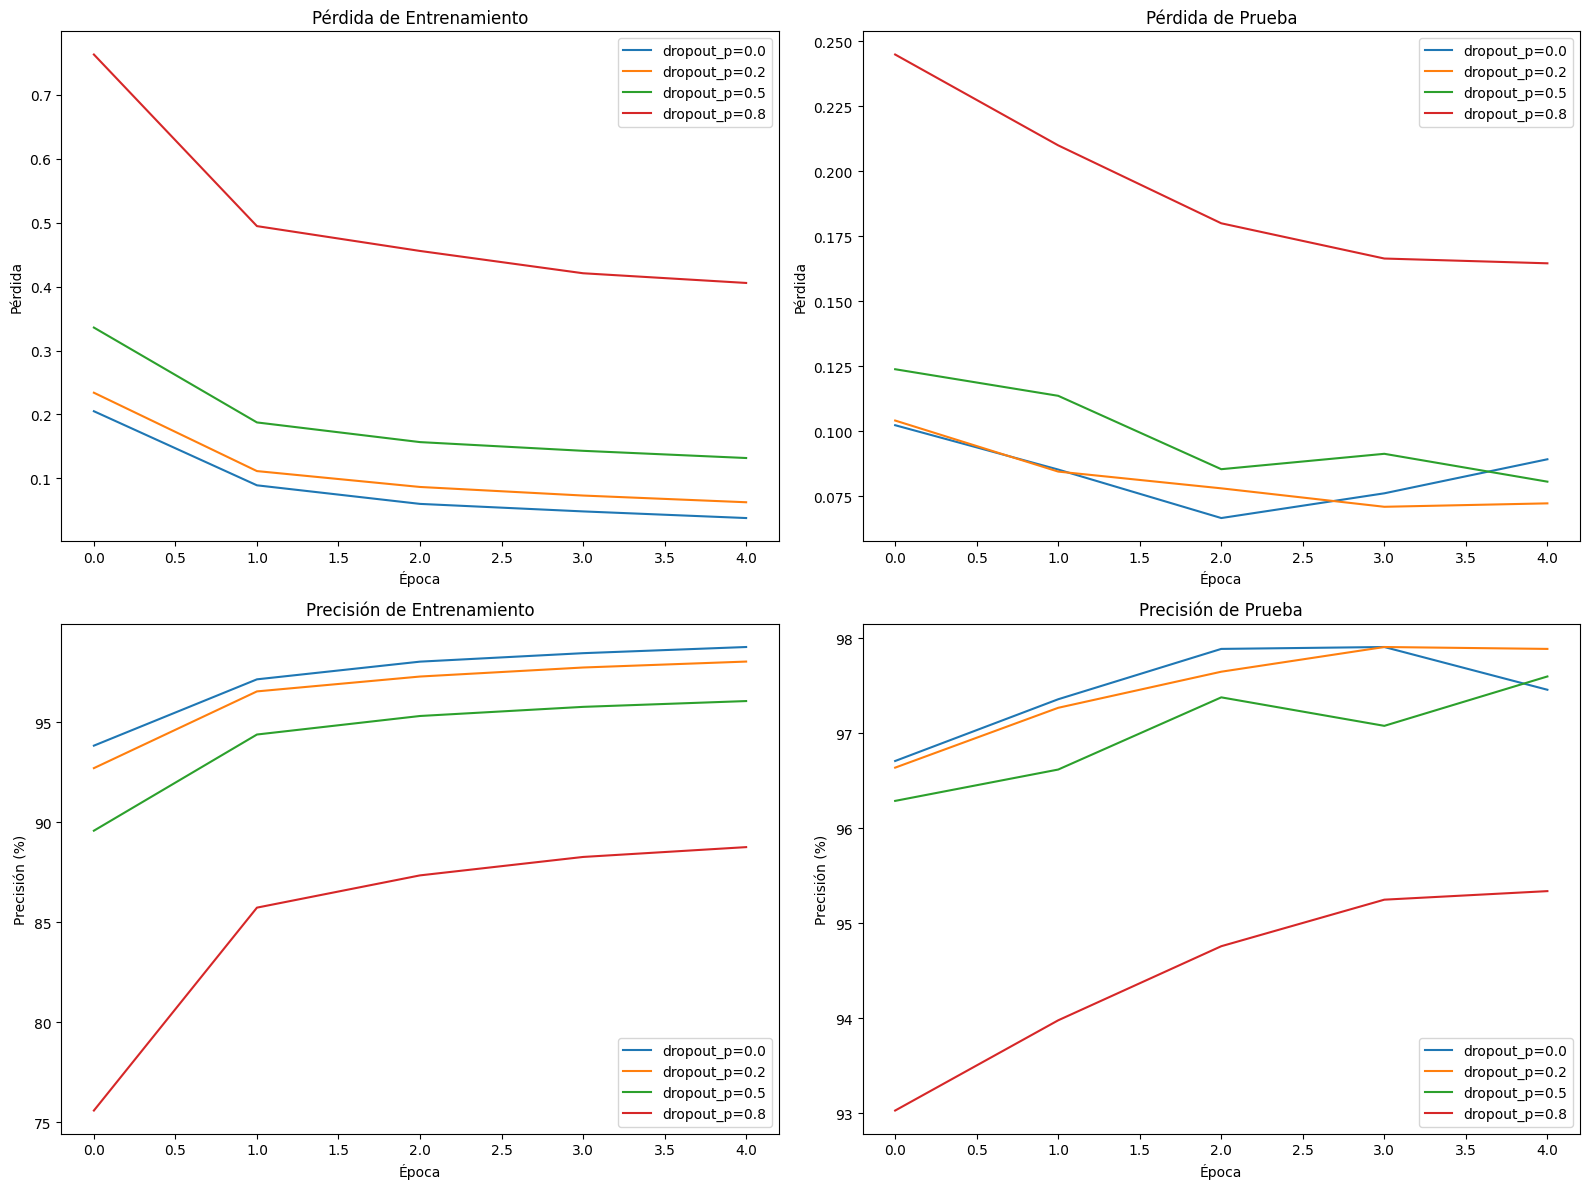

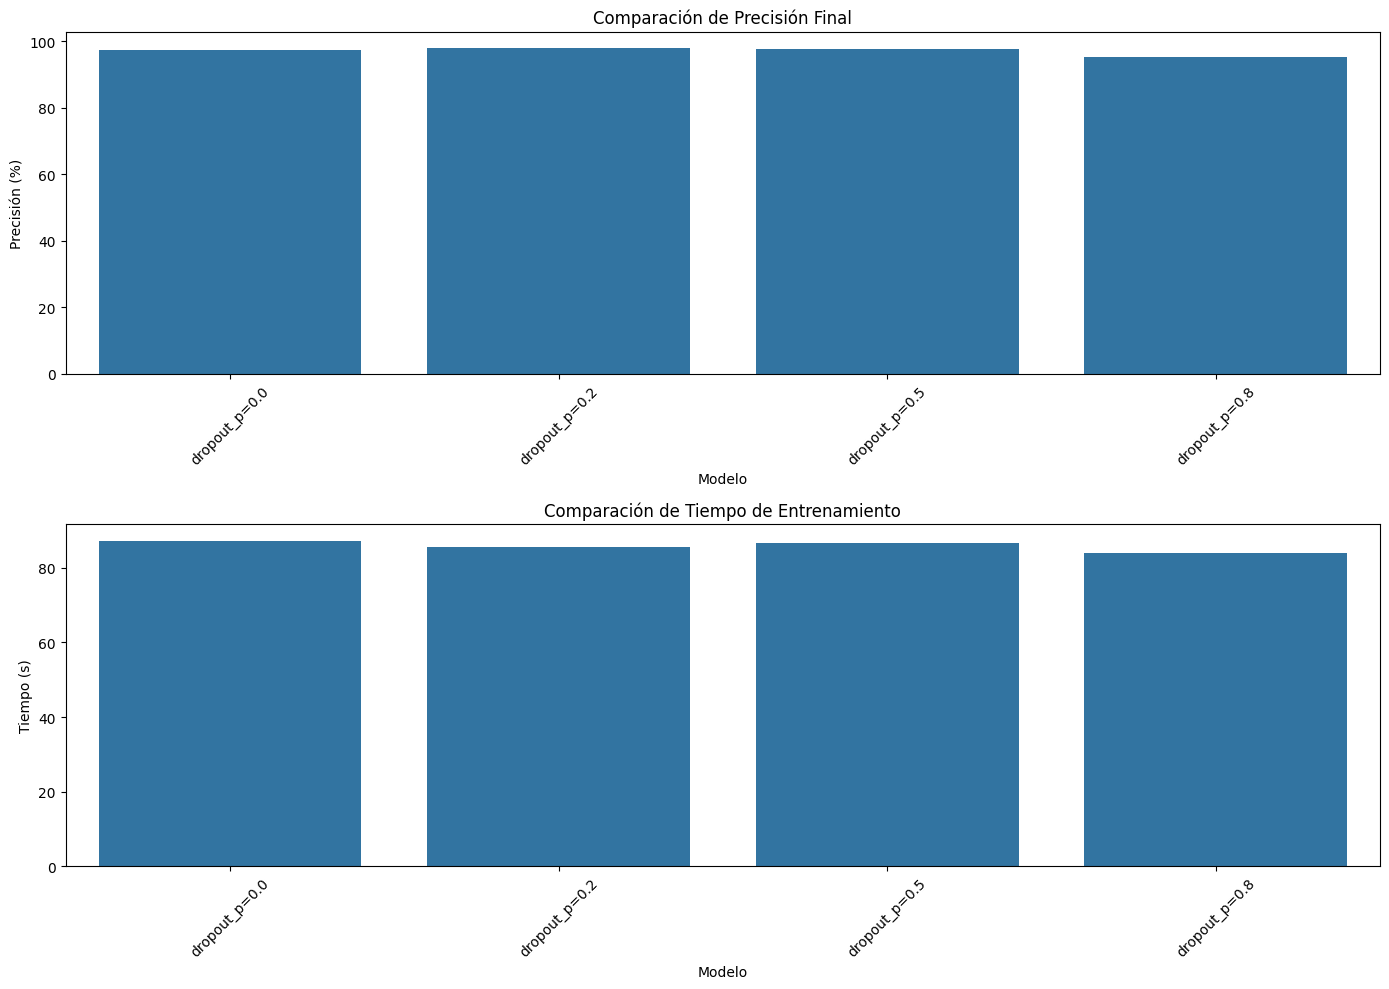


=== Análisis del efecto de la regularización L2 (weight_decay) ===
Utilizando dispositivo: cuda

--- Ejecutando experimento: weight_decay=0.0 ---
weight_decay=0.0 - Época 1/5 | Tiempo: 15.95s | Train Loss: 0.2030 | Train Acc: 93.79% | Test Loss: 0.1157 | Test Acc: 96.38%
weight_decay=0.0 - Época 2/5 | Tiempo: 16.33s | Train Loss: 0.0872 | Train Acc: 97.24% | Test Loss: 0.0790 | Test Acc: 97.64%
weight_decay=0.0 - Época 3/5 | Tiempo: 16.00s | Train Loss: 0.0591 | Train Acc: 98.14% | Test Loss: 0.0780 | Test Acc: 97.63%
weight_decay=0.0 - Época 4/5 | Tiempo: 16.36s | Train Loss: 0.0464 | Train Acc: 98.50% | Test Loss: 0.0850 | Test Acc: 97.67%
weight_decay=0.0 - Época 5/5 | Tiempo: 16.94s | Train Loss: 0.0389 | Train Acc: 98.73% | Test Loss: 0.0809 | Test Acc: 97.72%

weight_decay=0.0 completado en 81.58 segundos
Precisión final en prueba: 97.72%

--- Ejecutando experimento: weight_decay=0.001 ---
weight_decay=0.001 - Época 1/5 | Tiempo: 16.24s | Train Loss: 0.2098 | Train Acc: 93.60% |

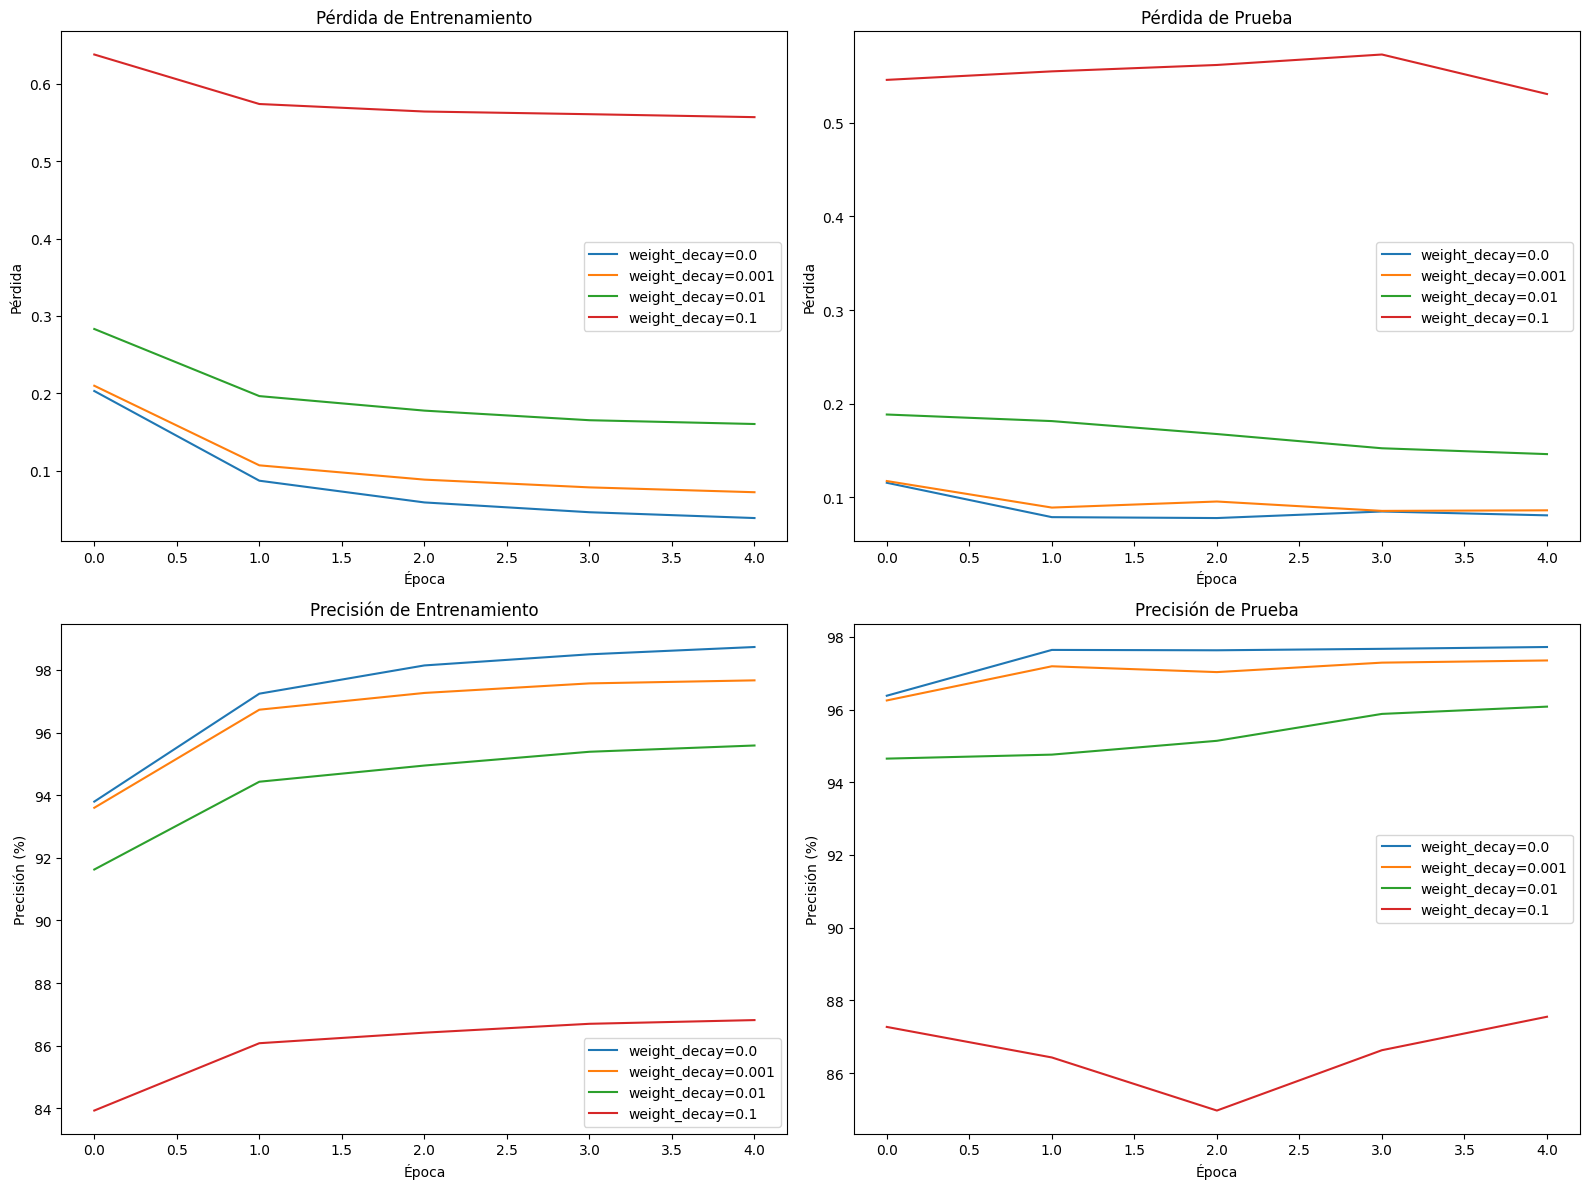

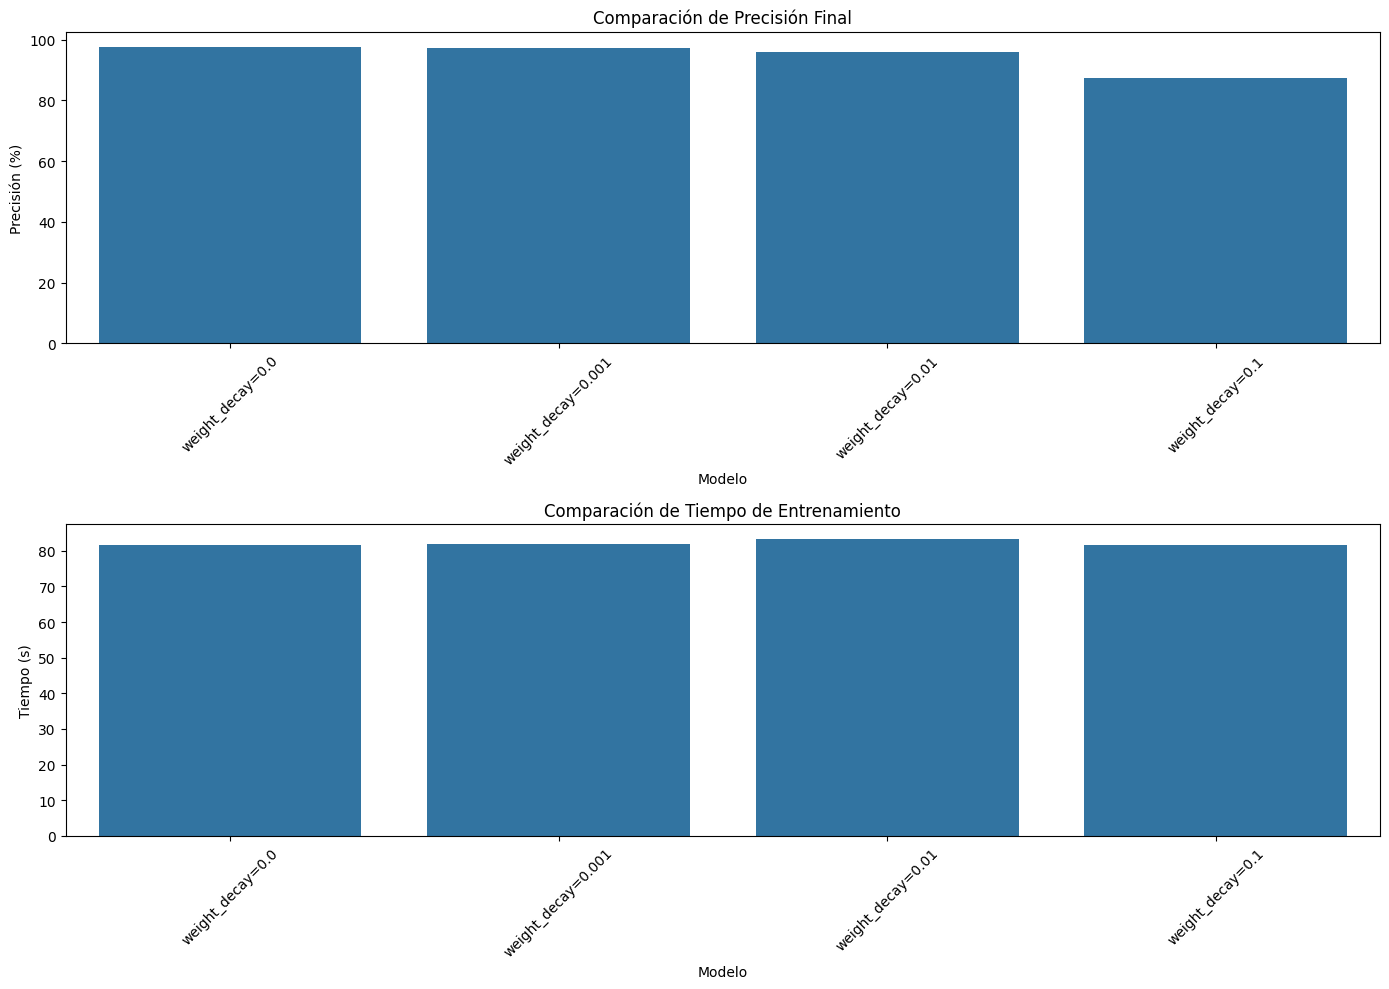


=== Análisis del efecto del tamaño del batch ===
Utilizando dispositivo: cuda

--- Ejecutando experimento: batch_size=16 ---
batch_size=16 - Época 1/5 | Tiempo: 22.58s | Train Loss: 0.2005 | Train Acc: 93.89% | Test Loss: 0.1103 | Test Acc: 96.37%
batch_size=16 - Época 2/5 | Tiempo: 22.04s | Train Loss: 0.0998 | Train Acc: 96.98% | Test Loss: 0.1075 | Test Acc: 97.05%
batch_size=16 - Época 3/5 | Tiempo: 23.16s | Train Loss: 0.0740 | Train Acc: 97.69% | Test Loss: 0.0953 | Test Acc: 97.44%
batch_size=16 - Época 4/5 | Tiempo: 23.92s | Train Loss: 0.0618 | Train Acc: 98.12% | Test Loss: 0.1098 | Test Acc: 97.10%
batch_size=16 - Época 5/5 | Tiempo: 23.84s | Train Loss: 0.0525 | Train Acc: 98.41% | Test Loss: 0.1046 | Test Acc: 97.41%

batch_size=16 completado en 115.54 segundos
Precisión final en prueba: 97.41%

--- Ejecutando experimento: batch_size=64 ---
batch_size=64 - Época 1/5 | Tiempo: 17.55s | Train Loss: 0.2071 | Train Acc: 93.68% | Test Loss: 0.1130 | Test Acc: 96.40%
batch_size

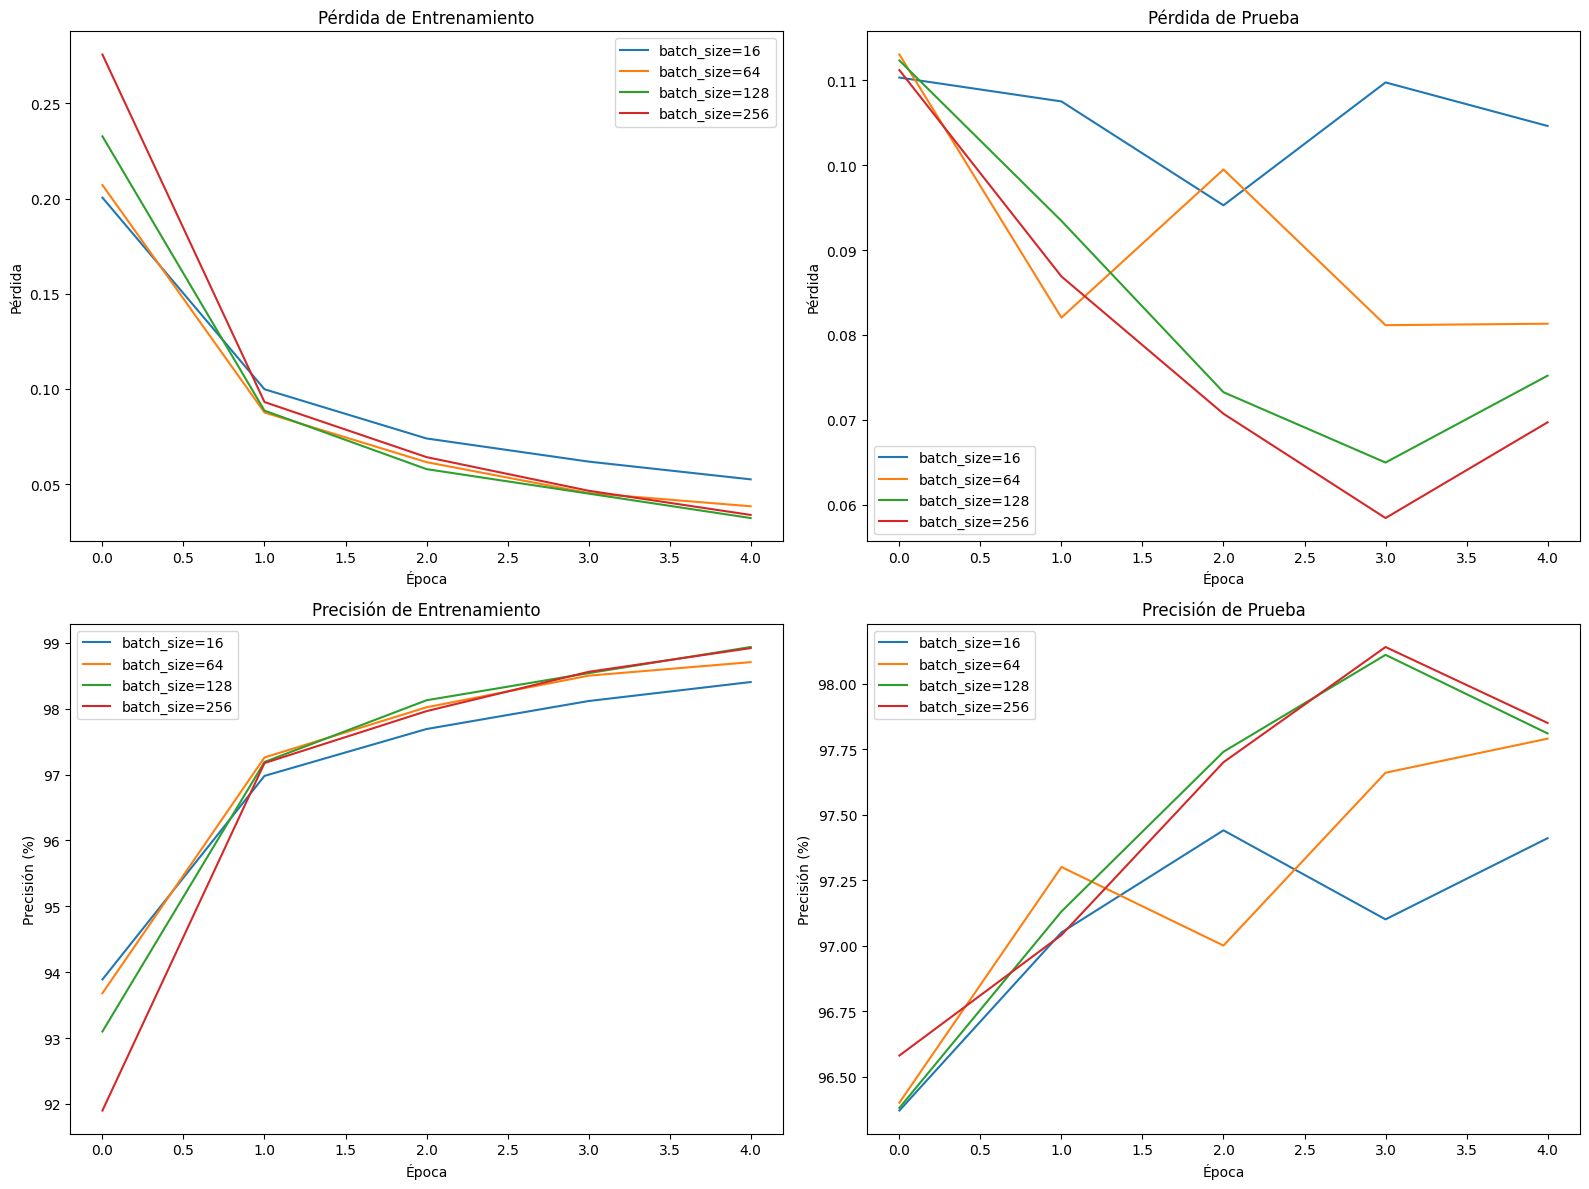

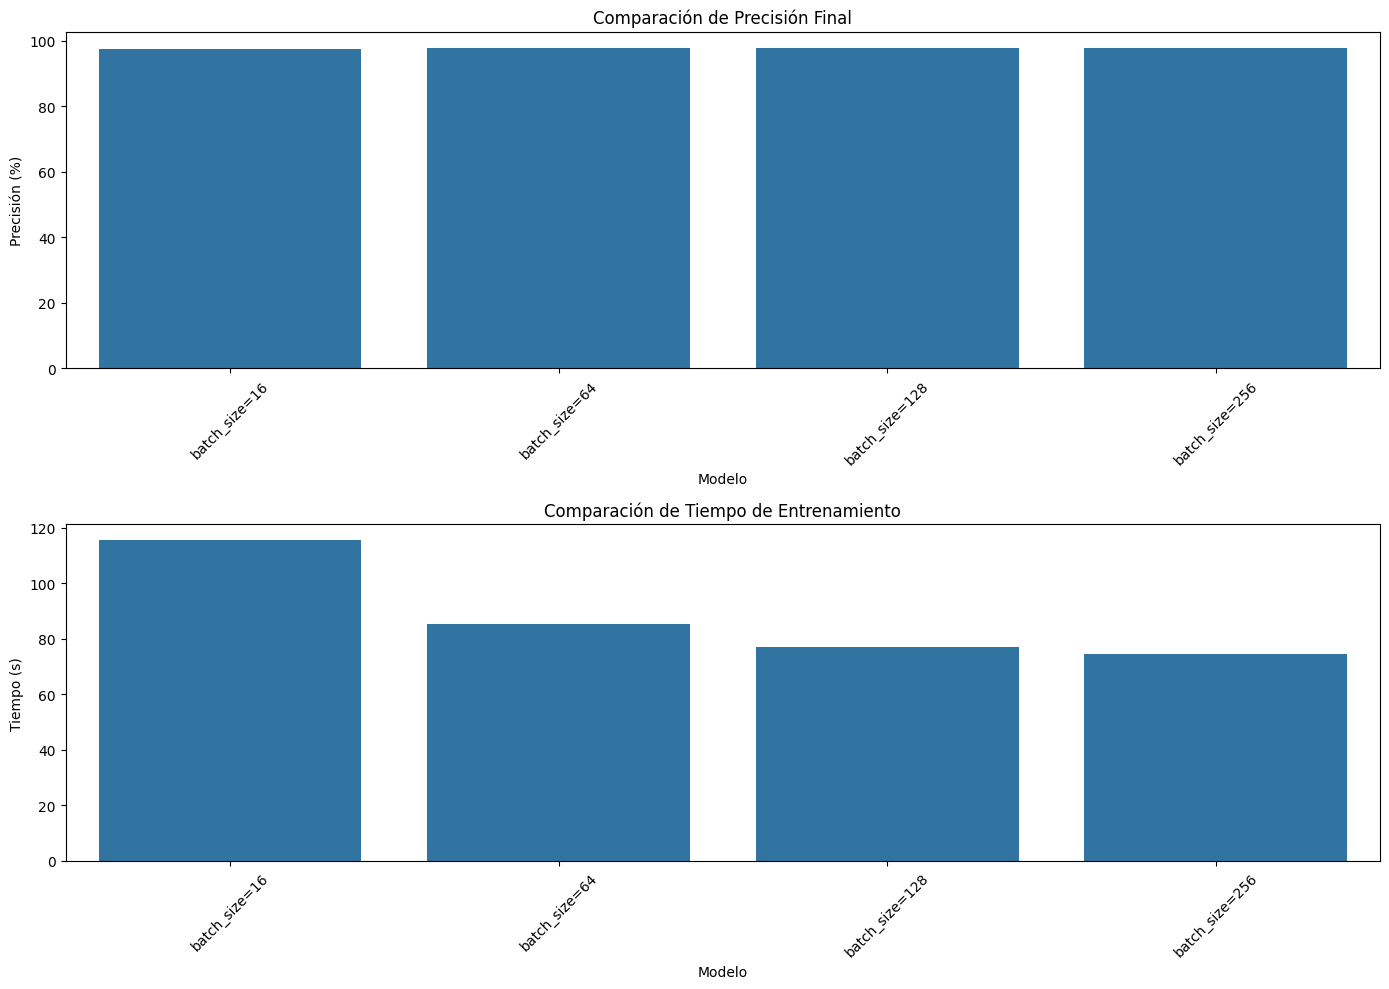


=== Resumen de Resultados ===
                                        name  final_accuracy  training_time
0                  Base (Sin Regularización)           97.91      84.797459
1  Con Regularización (Dropout 0.5, L2 0.01)           94.61      84.452552
2                              dropout_p=0.5           97.60      86.536213
3                              dropout_p=0.8           95.34      83.985079
4                          weight_decay=0.01           96.08      83.273744
5                           weight_decay=0.1           87.55      81.765761
6                             batch_size=128           97.81      77.200561
7                             batch_size=256           97.85      74.669165

Conclusiones:
1. El modelo con regularización tiene mejor desempeño:  No
2. El mejor valor de dropout es 0.2 con una precisión de 97.89%
3. El mejor valor de weight_decay (L2) es 0.0 con una precisión de 97.72%
4. El mejor tamaño de batch es 256 con una precisión de 97.85%
5. Tiempos

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Configuración de reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# 1. Carga del conjunto de datos MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Media y desviación estándar de MNIST
])

# Carga de datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Función para crear dataloaders con diferentes tamaños de batch
def create_dataloaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Crear dataloaders con batch_size inicial
batch_size = 64
train_loader, test_loader = create_dataloaders(batch_size)

# 2. Definición de la red neuronal
class MNIST_NN(nn.Module):
    def __init__(self, dropout_p=0.0):
        super(MNIST_NN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 500)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)

        self.fc2 = nn.Linear(500, 250)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_p)

        self.fc3 = nn.Linear(250, 10)

        # Flag para monitorear activaciones
        self.debug = False

    def forward(self, x):
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu1(x)

        if self.debug:
            print(f"Activaciones después de relu1: media={x.mean().item()}, std={x.std().item()}")

        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        if self.debug:
            print(f"Activaciones después de relu2: media={x.mean().item()}, std={x.std().item()}")

        x = self.dropout2(x)

        x = self.fc3(x)
        return x

# 3. Función de entrenamiento mejorada
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=5,
                model_name="Modelo", device="cpu", print_interval=1):
    """
    Entrena el modelo y registra métricas para análisis
    """
    # Mover modelo al dispositivo
    model.to(device)

    # Inicializar listas para almacenar métricas
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    epochs_times = []

    # Ciclo de entrenamiento
    for epoch in range(epochs):
        start_time = time.time()

        # Modo entrenamiento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Acumular estadísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcular métricas de entrenamiento
        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Modo evaluación
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Acumular estadísticas
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calcular métricas de prueba
        test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Calcular tiempo por época
        epoch_time = time.time() - start_time
        epochs_times.append(epoch_time)

        # Imprimir progreso
        if (epoch + 1) % print_interval == 0:
            print(f'{model_name} - Época {epoch+1}/{epochs} | '
                  f'Tiempo: {epoch_time:.2f}s | '
                  f'Train Loss: {epoch_loss:.4f} | '
                  f'Train Acc: {train_accuracy:.2f}% | '
                  f'Test Loss: {test_loss:.4f} | '
                  f'Test Acc: {test_accuracy:.2f}%')

    # Registrar tiempo total de entrenamiento
    total_time = sum(epochs_times)
    print(f'\n{model_name} completado en {total_time:.2f} segundos')
    print(f'Precisión final en prueba: {test_accuracies[-1]:.2f}%')

    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'epochs_times': epochs_times,
        'total_time': total_time,
        'final_accuracy': test_accuracies[-1]
    }

# 4. Comparar modelos con distintas configuraciones de regularización
def run_experiment(experiments):
    """Ejecuta múltiples experimentos y registra resultados"""
    results = []
    metrics_by_model = {}

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Utilizando dispositivo: {device}")

    for exp in experiments:
        print(f"\n--- Ejecutando experimento: {exp['name']} ---")

        # Crear dataloader con el batch_size especificado
        train_loader, test_loader = create_dataloaders(exp['batch_size'])

        # Crear modelo
        model = MNIST_NN(dropout_p=exp['dropout_p'])

        # Crear optimizador con la regularización L2 especificada
        optimizer = optim.Adam(
            model.parameters(),
            lr=exp['learning_rate'],
            weight_decay=exp['weight_decay']
        )

        # Criterio
        criterion = nn.CrossEntropyLoss()

        # Entrenar el modelo
        metrics = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            optimizer=optimizer,
            criterion=criterion,
            epochs=exp['epochs'],
            model_name=exp['name'],
            device=device
        )

        # Almacenar métricas
        metrics_by_model[exp['name']] = metrics

        # Registrar resultado para el análisis comparativo
        results.append({
            'name': exp['name'],
            'dropout': exp['dropout_p'],
            'weight_decay': exp['weight_decay'],
            'batch_size': exp['batch_size'],
            'final_accuracy': metrics['final_accuracy'],
            'training_time': metrics['total_time']
        })

    return results, metrics_by_model

# 5. Visualización avanzada
def plot_training_curves(metrics_by_model):
    """Visualiza curvas de pérdida y precisión"""
    plt.figure(figsize=(16, 12))

    # Subplot para pérdida de entrenamiento
    plt.subplot(2, 2, 1)
    for name, metrics in metrics_by_model.items():
        plt.plot(metrics['train_losses'], label=name)
    plt.title('Pérdida de Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Subplot para pérdida de prueba
    plt.subplot(2, 2, 2)
    for name, metrics in metrics_by_model.items():
        plt.plot(metrics['test_losses'], label=name)
    plt.title('Pérdida de Prueba')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Subplot para precisión de entrenamiento
    plt.subplot(2, 2, 3)
    for name, metrics in metrics_by_model.items():
        plt.plot(metrics['train_accuracies'], label=name)
    plt.title('Precisión de Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión (%)')
    plt.legend()

    # Subplot para precisión de prueba
    plt.subplot(2, 2, 4)
    for name, metrics in metrics_by_model.items():
        plt.plot(metrics['test_accuracies'], label=name)
    plt.title('Precisión de Prueba')
    plt.xlabel('Época')
    plt.ylabel('Precisión (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_comparison_bars(results):
    """Visualiza comparación de precisiones y tiempo de entrenamiento"""
    results_df = pd.DataFrame(results)

    plt.figure(figsize=(14, 10))

    # Barras de precisión
    plt.subplot(2, 1, 1)
    sns.barplot(x='name', y='final_accuracy', data=results_df)
    plt.title('Comparación de Precisión Final')
    plt.xlabel('Modelo')
    plt.ylabel('Precisión (%)')
    plt.xticks(rotation=45)

    # Barras de tiempo de entrenamiento
    plt.subplot(2, 1, 2)
    sns.barplot(x='name', y='training_time', data=results_df)
    plt.title('Comparación de Tiempo de Entrenamiento')
    plt.xlabel('Modelo')
    plt.ylabel('Tiempo (s)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(models, test_loader, device="cpu"):
    """Genera matrices de confusión para cada modelo"""
    fig, axs = plt.subplots(1, len(models), figsize=(15, 5))
    if len(models) == 1:
        axs = [axs]

    for i, (name, model) in enumerate(models.items()):
        # Poner modelo en modo evaluación
        model.eval()
        model.to(device)

        # Recopilar todas las predicciones
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Crear matriz de confusión
        cm = confusion_matrix(all_labels, all_preds)

        # Normalizar para obtener porcentajes
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Visualizar la matriz
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axs[i])
        axs[i].set_title(f'Matriz de Confusión - {name}')
        axs[i].set_xlabel('Predicción')
        axs[i].set_ylabel('Real')

    plt.tight_layout()
    plt.show()

# 6. Análisis de características de regularización
def analyze_regularization_effect(param_name, param_values, fix_params=None):
    """Analiza el efecto de un parámetro de regularización específico"""
    if fix_params is None:
        fix_params = {
            'dropout_p': 0.0,
            'weight_decay': 0.0,
            'batch_size': 64,
            'learning_rate': 0.001,
            'epochs': 5
        }

    experiments = []

    for value in param_values:
        # Crear una copia de los parámetros fijos
        params = fix_params.copy()
        # Modificar el parámetro específico
        params[param_name] = value

        experiments.append({
            'name': f"{param_name}={value}",
            'dropout_p': params['dropout_p'],
            'weight_decay': params['weight_decay'],
            'batch_size': params['batch_size'],
            'learning_rate': params['learning_rate'],
            'epochs': params['epochs']
        })

    # Ejecutar experimentos
    results, metrics = run_experiment(experiments)

    # Visualizar resultados
    plot_training_curves(metrics)
    plot_comparison_bars(results)

    return results, metrics

# 7. Ejecutar experimentos principales
def main():
    print("Análisis de Técnicas de Regularización en Redes Neuronales para MNIST")

    # Experimento 1: Modelo base vs Modelo con regularización
    experiments = [
        # Modelo sin regularización
        {
            'name': 'Base (Sin Regularización)',
            'dropout_p': 0.0,
            'weight_decay': 0.0,
            'batch_size': 64,
            'learning_rate': 0.001,
            'epochs': 5
        },
        # Modelo con dropout y regularización L2
        {
            'name': 'Con Regularización (Dropout 0.5, L2 0.01)',
            'dropout_p': 0.5,
            'weight_decay': 0.01,
            'batch_size': 64,
            'learning_rate': 0.001,
            'epochs': 5
        }
    ]

    results_base, metrics_base = run_experiment(experiments)

    print("\n=== Comparación Básica: Modelo Base vs Modelo Regularizado ===")
    plot_training_curves(metrics_base)
    plot_comparison_bars(results_base)

    # Crear los modelos para matrices de confusión
    models = {}
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for exp in experiments:
        model = MNIST_NN(dropout_p=exp['dropout_p'])
        model.load_state_dict(model.state_dict())  # Solo para asegurar que está recién inicializado
        model.to(device)

        # Configurar optimizer
        optimizer = optim.Adam(model.parameters(), lr=exp['learning_rate'], weight_decay=exp['weight_decay'])
        criterion = nn.CrossEntropyLoss()

        # Entrenar modelo
        train_loader, test_loader = create_dataloaders(exp['batch_size'])
        train_model(model, train_loader, test_loader, optimizer, criterion, epochs=exp['epochs'],
                   model_name=exp['name'], device=device, print_interval=5)

        models[exp['name']] = model

    # Mostrar matrices de confusión
    plot_confusion_matrices(models, test_loader, device)

    # Experimento 2: Analizar el efecto del dropout
    print("\n=== Análisis del efecto del dropout ===")
    dropout_values = [0.0, 0.2, 0.5, 0.8]
    results_dropout, metrics_dropout = analyze_regularization_effect('dropout_p', dropout_values)

    # Experimento 3: Analizar el efecto de la regularización L2
    print("\n=== Análisis del efecto de la regularización L2 (weight_decay) ===")
    l2_values = [0.0, 0.001, 0.01, 0.1]
    results_l2, metrics_l2 = analyze_regularization_effect('weight_decay', l2_values)

    # Experimento 4: Analizar el efecto del tamaño del batch
    print("\n=== Análisis del efecto del tamaño del batch ===")
    batch_values = [16, 64, 128, 256]
    results_batch, metrics_batch = analyze_regularization_effect('batch_size', batch_values)

    # Consolidar resultados
    all_results = results_base + results_dropout[2:] + results_l2[2:] + results_batch[2:]
    all_results_df = pd.DataFrame(all_results)

    # Mostrar tabla de resultados
    print("\n=== Resumen de Resultados ===")
    pd.set_option('display.max_rows', None)
    print(all_results_df[['name', 'final_accuracy', 'training_time']])

    print("\nConclusiones:")
    print("1. El modelo con regularización tiene mejor desempeño: ",
          "Sí" if results_base[1]['final_accuracy'] > results_base[0]['final_accuracy'] else "No")

    # Encontrar el mejor valor de dropout
    best_dropout = max(results_dropout, key=lambda x: x['final_accuracy'])
    print(f"2. El mejor valor de dropout es {best_dropout['dropout']} con una precisión de {best_dropout['final_accuracy']:.2f}%")

    # Encontrar el mejor valor de L2
    best_l2 = max(results_l2, key=lambda x: x['final_accuracy'])
    print(f"3. El mejor valor de weight_decay (L2) es {best_l2['weight_decay']} con una precisión de {best_l2['final_accuracy']:.2f}%")

    # Encontrar el mejor tamaño de batch
    best_batch = max(results_batch, key=lambda x: x['final_accuracy'])
    print(f"4. El mejor tamaño de batch es {best_batch['batch_size']} con una precisión de {best_batch['final_accuracy']:.2f}%")

    # Tiempo de convergencia por tamaño de batch
    convergence_times = [result['training_time'] for result in results_batch]
    print(f"5. Tiempos de entrenamiento por tamaño de batch: {[f'{t:.2f}s' for t in convergence_times]}")

# Ejecutar el programa principal
if __name__ == "__main__":
    main()

<font color='green'>**Fin Actividad 3**</font>

# <font color='purple' style='bold' size=5>**EXPERIMENTO** </font>

**Comparar el efecto de distintos valores de dropout en la precisión de validación.**

La idea es:

Definir un mismo modelo, pero con tres probabilidades de dropout diferentes: 0 (sin dropout), 0.2 y 0.5.

Entrenar cada variante durante unas pocas épocas (por ejemplo 3–5) usando tu trainloader y medir la precisión en testloader.

Observar cómo varía la capacidad de generalización según la fuerza del dropout.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Usamos los mismos loaders que ya tienes:
# trainloader, testloader

class Net(nn.Module):
    def __init__(self, p_drop):
        super(Net, self).__init__()
        # Red muy simple: 784 → 256 → 10
        self.fc1 = nn.Linear(28*28, 256)
        self.dropout = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train_and_validate(p_drop, epochs=3, lr=0.003):
    model = Net(p_drop)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Validación
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            log_ps = model(images)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class.squeeze() == labels
            correct += equals.sum().item()
            total += labels.size(0)
    val_acc = correct / total * 100
    return val_acc

# Experimentamos con p = 0.0, 0.2 y 0.5
drop_probs = [0.0, 0.2, 0.5]
results = {}

for p in drop_probs:
    acc = train_and_validate(p, epochs=3)
    results[p] = acc
    print(f'Dropout p={p}: Validación {acc:.2f}%')

# Ejemplo de salida esperada:
# Dropout p=0.0: Validación 83.45%
# Dropout p=0.2: Validación 85.30%
# Dropout p=0.5: Validación 82.10%


Dropout p=0.0: Validación 96.07%
Dropout p=0.2: Validación 95.70%
Dropout p=0.5: Validación 94.37%


**Qué muestra este experimento**

**Con p=0.0**(sin dropout) normalmente obtienes buen ajuste de entrenamiento, pero menor capacidad de generalizar (validación más baja).

**Con p=0.2** suele mejorar la validación al evitar overfitting.

**Con p=0.5** a veces es excesivo y reduce tanto la capacidad de entrenamiento que baja la validación.

# <font color='purple' style='bold' size=5>**FIN EXPERIMENTO** </font>

# <font color='purple' style='bold' size=5>**MATERIAL ADICIONAL** </font>

**Origen de Dropout**

La técnica de dropout fue propuesta en 2014 por Nitish Srivastava, Geoffrey Hinton y colaboradores en el artículo “Dropout: A Simple Way to Prevent Neural Networks from Overfitting” (Srivastava et al., 2014)¹. Desde entonces se ha convertido en un estándar de facto para regularizar redes profundas.

**Dropout como promedio de modelos**

Intuitivamente, cada minibatch con dropout “apaga” un subconjunto distinto de neuronas: durante el entrenamiento el modelo aprende una especie de ensamblado (bagging) de muchas subredes. En inferencia, al usar todas las neuronas, se obtiene un modelo equivalente al promedio de todas esas subredes.

**Variantes específicas para convoluciones**

**SpatialDropout2D:** propuesto en Keras/TensorFlow, abandona canales completos en lugar de neuronas individuales, preservando la estructura espacial de las características².

**DropConnect (Wan et al., 2013):** en vez de apagar salidas de neuronas, apaga conexiones (pesos) aleatorias.

**Monte Carlo Dropout para medir incertidumbre**

En lugar de desactivar dropout en inferencia (mode .eval()), podemos mantenerlo activo y realizar varias pasadas sobre la misma entrada. Así estimamos la incertidumbre de nuestras predicciones (Gal & Ghahramani, 2016)³.

In [17]:
import torch
import torch.nn.functional as F

def mc_dropout_predict(model, x, T=30):
    """
    Realiza T pasadas con dropout activo y devuelve
    la media y varianza de las predicciones.
    """
    model.train()  # IMPORTANTE: keep dropout on
    preds = []
    with torch.no_grad():
        for _ in range(T):
            log_ps = model(x)               # salida en log-probabilidades
            preds.append(torch.exp(log_ps)) # convertir a probabilidades
    preds = torch.stack(preds)            # shape: [T, batch, classes]
    mean_p = preds.mean(dim=0)            # [batch, classes]
    var_p  = preds.var(dim=0)             # [batch, classes]
    return mean_p, var_p

# Ejemplo de uso:
model.eval()               # normalmente en evaluación
images, labels = next(iter(testloader))
mean_p, var_p = mc_dropout_predict(model, images, T=50)

# para un ejemplo:
pred_class = torch.argmax(mean_p[0]).item()
uncertainty = var_p[0][pred_class].item()
print(f"Predicción: {pred_class}  –  Incertidumbre: {uncertainty:.4f}")


Predicción: 2  –  Incertidumbre: 0.0000


**¿Qué aporta?** Podemos identificar ejemplos donde el modelo “no está seguro” (varianza alta), útil en tareas críticas como diagnóstico médico o sistemas de conducción autónoma.

**Referencias bibliográficas**

Srivastava, N., Hinton, G. E., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research, 15, 1929–1958.

Tompson, J., Goroshin, R., Jain, A., LeCun, Y., & Bregler, C. (2015). Efficient Object Localization Using Convolutional Networks. In Proceedings of CVPR.

Gal, Y., & Ghahramani, Z. (2016). Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. In Proceedings of ICML.

# <font color='purple' style='bold' size=5>**FIN MATERIAL ADICIONAL** </font>